<a href="https://colab.research.google.com/github/tomascammisa/Challenge-Plataforma-Educativa/blob/main/Challenge_Ed_Machina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# El problema:
Nos llegaron los datos  de un cliente que necesita ayuda. El mismo, viene de una institución que aún tiene problemas en sus datos y necesita tu colaboración para aclarar si estos datos pueden hacer un buen modelo que prediga la probabilidad de aprobación de un cierto curso o no. Estos datos se encuentran en el archivo con el nombre: dataset_challenge_edmachina.csv .
Se puede observar que hay dos posibles variables a predecir (target y target_b). Con los datos de las variables esperamos que puedas ayudar al cliente a determinar qué target hace más lógica respecto a cómo interactúan con las otras variables. Para ello es importante poder describir el comportamiento de las variables, cómo se relacionan entre sí y ver si pueden ayudarnos en la predicción de nuestro modelo.





# Parte I: Análisis Exploratorio

In [348]:
# Importamos librerias que usaremos
import numpy as np
import pandas as pd

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# preprocesamiento de datos
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
)
import missingno as msno
from sklearn.impute import SimpleImputer

# aprendizaje automático supervisado
from random import sample
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict,
    GridSearchCV,
    train_test_split,
)
from scipy.stats import loguniform

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

# usamos sklearn variancethreshold para descartar variables constantes
from sklearn import preprocessing
import logging
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

In [257]:
# Conectamos colab a nuestro drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [258]:
# Importamos nuestro dataset

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ed Machina/dataset_challenge_edmachina - dataset_challenge_edmachina.csv', encoding = 'unicode_escape')
df.head()

<ipython-input-258-6afd03763d25>:3: DtypeWarning:

Columns (8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
0,FG256,111444477788333664,Idiomas,1342795678817385,M,25,2021-01,2,1720800000.0,1706400000.0,1965600000.0,87.0,98.0,89.0,443.0,5.0,6.0,279.0,0,1
1,DE5355,133344477788333664,MatemÃ¡tica,2370785941394635,F,28,2021-01,2,1972800000.0,1731600000.0,1879200000.0,79.0,97.0,92.0,266.0,5.0,2.0,256.0,0,1
2,HI4650,133344477788333664,MatemÃ¡tica,1812868984238778,M,26,2021-02,1,1872000000.0,1429200000.0,1735200000.0,76.0,65.0,98.0,481.0,6.0,5.0,369.0,0,0
3,NM4364,133344499988333664,Lengua,-135586768863004,F,18,2023-02,1,2030400000.0,1767600000.0,1623600000.0,91.0,71.0,65.0,374.0,5.0,5.0,180.0,0,0
4,JK3568,111444477488373664,Lengua,-2150952171478082,F,18,2020-02,2,1800000000.0,1688400000.0,1972800000.0,68.0,88.0,60.0,360.0,4.0,2.0,107.0,0,0


In [259]:
df.shape

(208842, 20)

Nuestro dataset cuenta efectivamente con las 20 columnas (de las cuales dos son potenciales targuet), y con mas de 200 mil filas

In [260]:
# Veamos los tipos de datos
df.dtypes

matricula                      object
course_id                       int64
area                           object
user_id                        object
sexo                           object
edad                            int64
ejercicio_academico            object
semestre                        int64
tiempo_actividades             object
tiempo_desarrollo              object
tiempo_general                 object
valor_calif_primer_parcial     object
valor_calif_segundo_parcial    object
valor_calif_final_real         object
sum_points                     object
count_points                   object
count_subbmision               object
sum_score                      object
target                          int64
target_b                        int64
dtype: object

In [261]:
# Comprobar el número de elementos nulos del data frame
df.isnull().sum()

matricula                      0
course_id                      0
area                           0
user_id                        0
sexo                           0
edad                           0
ejercicio_academico            0
semestre                       0
tiempo_actividades             0
tiempo_desarrollo              0
tiempo_general                 0
valor_calif_primer_parcial     0
valor_calif_segundo_parcial    0
valor_calif_final_real         0
sum_points                     0
count_points                   0
count_subbmision               0
sum_score                      0
target                         0
target_b                       0
dtype: int64

A partir de ver el tipo de datos con el que contamos observamos algunos errores:
1. Ejercicio Academico refiere a una fecha, pero tiene como tipo de dato object
2. Columnas desde tiempo_actividades en adelante se encuentran como object cuando son en realidad variables numericas

In [262]:
# Convertir ejercicio_academico en formato de fecha
# Primero convertimos a formato fecha
df['ejercicio_academico'] = pd.to_datetime(df['ejercicio_academico'], format='%Y-%m')

#Luego dejamos solo el periodo mensual
df['ejercicio_academico'] = df['ejercicio_academico'].dt.to_period('M')

In [263]:
# Creamos una copia del DataFrame original df
df_ = df.copy()

#Seleccionamos nuestras variables object a partir de la columna tiempo_actividades
object_columns = df_.iloc[:, 8:].select_dtypes(include=['object'])

# Convertir variables object a tipo numerico
for column in object_columns:
    df_[column] = pd.to_numeric(df_[column], errors='coerce')

# Comprobar el tipo de datos
df_.dtypes

matricula                         object
course_id                          int64
area                              object
user_id                           object
sexo                              object
edad                               int64
ejercicio_academico            period[M]
semestre                           int64
tiempo_actividades               float64
tiempo_desarrollo                float64
tiempo_general                   float64
valor_calif_primer_parcial       float64
valor_calif_segundo_parcial      float64
valor_calif_final_real           float64
sum_points                       float64
count_points                     float64
count_subbmision                 float64
sum_score                        float64
target                             int64
target_b                           int64
dtype: object

In [264]:
df_.head()

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
0,FG256,111444477788333664,Idiomas,1342795678817385,M,25,2021-01,2,1.720800e+09,1.706400e+09,1.965600e+09,87.0,98.0,89.0,443.0,5.0,6.0,279.0,0,1
1,DE5355,133344477788333664,MatemÃ¡tica,2370785941394635,F,28,2021-01,2,1.972800e+09,1.731600e+09,1.879200e+09,79.0,97.0,92.0,266.0,5.0,2.0,256.0,0,1
2,HI4650,133344477788333664,MatemÃ¡tica,1812868984238778,M,26,2021-02,1,1.872000e+09,1.429200e+09,1.735200e+09,76.0,65.0,98.0,481.0,6.0,5.0,369.0,0,0
3,NM4364,133344499988333664,Lengua,-135586768863004,F,18,2023-02,1,2.030400e+09,1.767600e+09,1.623600e+09,91.0,71.0,65.0,374.0,5.0,5.0,180.0,0,0
4,JK3568,111444477488373664,Lengua,-2150952171478082,F,18,2020-02,2,1.800000e+09,1.688400e+09,1.972800e+09,68.0,88.0,60.0,360.0,4.0,2.0,107.0,0,0


Ahora si tenemos nuestro df con los tipos de datos correctos. Veamos ahora si tenemos nulos en nuestras columnas

In [265]:
# Comprobamos el número de elementos nulos del data frame
df_.isnull().sum()

matricula                           0
course_id                           0
area                                0
user_id                             0
sexo                                0
edad                                0
ejercicio_academico                 0
semestre                            0
tiempo_actividades             104421
tiempo_desarrollo              104418
tiempo_general                 104418
valor_calif_primer_parcial     104421
valor_calif_segundo_parcial    104421
valor_calif_final_real         104421
sum_points                     104421
count_points                   104421
count_subbmision               104421
sum_score                      104421
target                              0
target_b                            0
dtype: int64

Al hacer la conversion de datos de object a numericos perdimos la mitad de los datos.
Veamos cuales son estas filas y quedatos tenina en estas columnas previo a la conversion

In [266]:
# Identificamos los valores problemáticos (NaN)
problematic_values = df_[df_.isna().any(axis=1)]
problematic_values.head()

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
104421,DE35098,1114444777885219664,MatemÃ¡tica,7393877091023565,M,29,2020-02,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
104422,BC38789,552244499988333664,Ciencias,7314490771995508,M,23,2023-02,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
104423,EF49675,111444477788333664,Idiomas,7016833752787235,F,21,2023-02,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
104424,KL39583,133344499988398884,Ciencias,7100263326495344,M,34,2021-02,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
104425,EF36733,133344499988333664,Lengua,"7,50379E+15",M,32,2021-01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [267]:
# Filtramos el DataFrame para mantener solo la fila con el valor "DE35098" en la columna "matricula"
df_filtered = df[df['matricula'] == "DE35098"]
df_filtered

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
104421,DE35098,1114444777885219664,MatemÃ¡tica,7393877091023565,M,29,2020-02,2,17.207.999.997.556.400,17.064.000.003.492.500,19.655.999.994.274.500,8.717.484.305.946.270,9.861.875.140.098.810,886.888.058.368.816,44.276.598.704.568.800,5.030.123.004.788.040,6.274.999.049.240.140,2.786.028.996.609.600,1,1


Los valores perdidos en la transformación numerica de las columnas corresponden a filas que, aparentenemente, tendrías mal cargador los regitros.

In [268]:
# Verifiquemos ahora los valores unicos por columna
for column in df.columns:
    unique_count = df[column].nunique()
    print(f"En la columna '{column}' hay {unique_count} valores únicos.")

En la columna 'matricula' hay 168156 valores únicos.
En la columna 'course_id' hay 10 valores únicos.
En la columna 'area' hay 4 valores únicos.
En la columna 'user_id' hay 208192 valores únicos.
En la columna 'sexo' hay 2 valores únicos.
En la columna 'edad' hay 17 valores únicos.
En la columna 'ejercicio_academico' hay 8 valores únicos.
En la columna 'semestre' hay 2 valores únicos.
En la columna 'tiempo_actividades' hay 104668 valores únicos.
En la columna 'tiempo_desarrollo' hay 104440 valores únicos.
En la columna 'tiempo_general' hay 104441 valores únicos.
En la columna 'valor_calif_primer_parcial' hay 104501 valores únicos.
En la columna 'valor_calif_segundo_parcial' hay 104501 valores únicos.
En la columna 'valor_calif_final_real' hay 104501 valores únicos.
En la columna 'sum_points' hay 105218 valores únicos.
En la columna 'count_points' hay 104433 valores únicos.
En la columna 'count_subbmision' hay 104435 valores únicos.
En la columna 'sum_score' hay 105216 valores únicos.
E

Nuestro datafame tiene en total 208842 filas, pero solo 168156 matricula distintas. Es decir, que habría, en teoría, 168156 alumnos distintos.

In [269]:
# Filtramos y ordenamos las filas duplicadas por la columna "matricula"
duplicates_filtered = df[df.duplicated(subset=['matricula'],keep=False)]

# Verificamos
duplicates_filtered

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
3,NM4364,133344499988333664,Lengua,-135586768863004,F,18,2023-02,1,2030400000.0,1767600000.0,1623600000.0,91.0,71.0,65.0,374.0,5.0,5.0,180.0,0,0
4,JK3568,111444477488373664,Lengua,-2150952171478082,F,18,2020-02,2,1800000000.0,1688400000.0,1972800000.0,68.0,88.0,60.0,360.0,4.0,2.0,107.0,0,0
7,BC2841,133344499988333664,Lengua,"-5,65886E+15",M,22,2021-02,1,1882800000.0,1562400000.0,1569600000.0,66.0,73.0,86.0,445.0,3.0,3.0,460.0,0,0
8,AB8805,111444477488373664,Lengua,"-6,16439E+15",M,19,2021-01,1,2120400000.0,1504800000.0,1670400000.0,66.0,96.0,67.0,132.0,3.0,2.0,402.0,0,0
11,BC4397,133344477788333664,MatemÃ¡tica,-54030341432302,F,20,2020-02,1,2073600000.0,1609200000.0,1918800000.0,72.0,75.0,76.0,230.0,2.0,3.0,107.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208823,GH25594,111444477788333664,Idiomas,7068122274681244,M,28,2020-01,1,16.416.000.000.603.600,13.896.000.004.301.600,16.631.999.998.658.400,61.236.385.706.690.200,6.412.526.601.342.020,6.292.507.685.334.090,25.195.073.620.934.900,2.533.008.507.205.290,3.568.291.565.850.670,10.180.655.079.292.900,1,0
208828,LN24874,111444477788999664,Idiomas,6925681216789445,M,29,2022-02,2,15.696.000.002.932.200,14.112.000.003.927.000,17.567.999.996.273.800,6.867.277.121.224.020,6.797.111.271.596.580,6.294.539.221.343.800,28.962.970.148.811.900,22.512.600.273.605.400,66.012.861.449.221.500,18.744.005.986.149.100,1,0
208830,BC41242,552244499988333664,Ciencias,7109432611449629,F,33,2023-02,2,173.879.999.976.458,13.967.999.996.625.200,15.695.999.996.547.800,740.812.145.267.917,6.269.740.329.724.140,6.670.907.248.151.990,2.906.264.535.606.740,5.882.681.031.376.160,6.180.175.496.008.560,24.628.959.797.440.900,1,1
208837,BC37760,111444477788999664,Idiomas,7017889369165099,M,34,2023-01,1,15.732.000.002.743.800,14.075.999.989.706.300,16.740.000.004.242.800,711.008.777.137.177,6.817.801.433.810.100,6.751.208.784.362.880,27.210.204.822.314.700,21.249.926.083.792.500,798.332.848.765.788,21.498.678.019.684.500,1,0


In [270]:
# Filtramos el DataFrame para mantener solo la fila con el valor "HI24588" en la columna "matricula"
matricula_duplicada = duplicates_filtered[duplicates_filtered['matricula'] == "HI24588"]
matricula_duplicada

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
145266,HI24588,133344477755533664,MatemÃ¡tica,7133473648526775,M,23,2022-01,1,15.191.999.994.126.000,16.416.000.000.210.500,15.696.000.004.361.900,8.964.783.411.597.440,9.065.931.564.083.460,6.045.793.221.570.510,1.742.931.193.768.570,26.341.976.880.963.800,27.309.834.935.332.000,22.909.377.194.535.100,1,1
208838,HI24588,1114444777885219664,MatemÃ¡tica,7588713145771945,F,24,2022-02,2,17.208.000.003.194.800,13.967.999.996.671.000,16.524.000.000.104.800,7.011.388.512.074.210,6.121.584.519.236.940,6.539.485.995.049.230,13.534.081.988.682.100,6.907.023.802.502.640,32.232.831.347.246.500,13.963.479.792.718.800,1,0


In [271]:
# Filtramos el DataFrame para mantener solo la fila con el valor "NM4364" en la columna "matricula"
matricula_duplicada_ = duplicates_filtered[duplicates_filtered['matricula'] == "NM4364"]
matricula_duplicada_

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
3,NM4364,133344499988333664,Lengua,-135586768863004,F,18,2023-02,1,2030400000.0,1767600000.0,1623600000.0,91.0,71.0,65.0,374.0,5.0,5.0,180.0,0,0
4943,NM4364,133344499988398884,Ciencias,-5332225548467258,F,18,2022-02,2,1980000000.0,1663200000.0,1929600000.0,71.0,70.0,77.0,155.0,6.0,5.0,139.0,0,0
44851,NM4364,133344499988398884,Ciencias,-1938123660607234,M,26,2022-01,1,1576800000.0,1638000000.0,1951200000.0,69.0,82.0,90.0,354.0,4.0,4.0,444.0,0,1


In [272]:
# Filtramos y ordenamos las filas duplicadas por la columna "matricula"
duplicates_filtered_problematic_values= problematic_values[problematic_values.duplicated(subset=['matricula'],keep=False)]

# Verificamos
duplicates_filtered_problematic_values

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
104430,KL40530,133344477788333664,MatemÃ¡tica,7598356232129257,M,21,2021-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
104432,NM39749,533344499988333664,Lengua,7701635662397053,F,22,2023-01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
104434,LN46997,552244499988333664,Ciencias,"7,46587E+15",M,30,2023-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
104438,AB34105,111444477788999664,Idiomas,7862052242313423,M,25,2023-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
104450,MO33402,133344499988398884,Ciencias,7856219446028032,M,34,2022-01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208823,GH25594,111444477788333664,Idiomas,7068122274681244,M,28,2020-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
208828,LN24874,111444477788999664,Idiomas,6925681216789445,M,29,2022-02,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
208830,BC41242,552244499988333664,Ciencias,7109432611449629,F,33,2023-02,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
208837,BC37760,111444477788999664,Idiomas,7017889369165099,M,34,2023-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


Resumiendo, nos encontramos con dos problemas.

Por un lado, tenemos una duplicación en las mastriculas para personas distintas. Personas, aparentemente distintas, de distinto sexo, edad o user_id, comparten la misma matricula. En teoría esto no debería poder ocurrir. Por eso, modificaremos las matriculas repetidas.

Por otro lado, nos encontramos con una gran cantidad de datos aparententemente mal cargados. Normalmalmente consultaríamos con el ingeniero de datos sobre la veracidad de los mismos. Como en este caso no es posible, procederemos a descartarlos.

In [273]:
# Primero, creamos un diccionario para realizar un seguimiento de cuántas veces se encuentra cada valor duplicado.
duplicados_count = {}

def agregar_numero_secuencial(matricula):
    if matricula in duplicados_count:
        duplicados_count[matricula] += 1
        return f"{matricula}-{duplicados_count[matricula]}"
    else:
        duplicados_count[matricula] = 0
        return matricula

# Aplicamos la función agregar_numero_secuencial a la columna 'matricula' para modificar los valores duplicados.
df_['matricula'] = df_['matricula'].apply(agregar_numero_secuencial)

# Verificamos la cantidad de valores únicos en matricula
print(df_['matricula'].nunique())

208842


In [274]:
#Verificamos un caso
matricula_duplicada = df_.loc[df_['matricula'].str.startswith('NM4364')]
matricula_duplicada

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
3,NM4364,133344499988333664,Lengua,-135586768863004,F,18,2023-02,1,2.030400e+09,1.767600e+09,1.623600e+09,91.0,71.0,65.0,374.0,5.0,5.0,180.0,0,0
4943,NM4364-1,133344499988398884,Ciencias,-5332225548467258,F,18,2022-02,2,1.980000e+09,1.663200e+09,1.929600e+09,71.0,70.0,77.0,155.0,6.0,5.0,139.0,0,0
44851,NM4364-2,133344499988398884,Ciencias,-1938123660607234,M,26,2022-01,1,1.576800e+09,1.638000e+09,1.951200e+09,69.0,82.0,90.0,354.0,4.0,4.0,444.0,0,1


Resuelto el tema matriculas, procedemos con eliminar los valores NaN de nuestro df, correspondiente a aquelklos valores problematicos en nuestras columnas numericas.

In [275]:
# Utilizamos como subset la columna valor_calif_primer_parcial para eliminar solo squellos valores mal cargados
df_ = df_.dropna(subset=['valor_calif_primer_parcial'])

# Comprobamos el número de elementos nulos del data frame
df_.isnull().sum()

matricula                      0
course_id                      0
area                           0
user_id                        0
sexo                           0
edad                           0
ejercicio_academico            0
semestre                       0
tiempo_actividades             0
tiempo_desarrollo              0
tiempo_general                 0
valor_calif_primer_parcial     0
valor_calif_segundo_parcial    0
valor_calif_final_real         0
sum_points                     0
count_points                   0
count_subbmision               0
sum_score                      0
target                         0
target_b                       0
dtype: int64

In [276]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104421 entries, 0 to 104420
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype    
---  ------                       --------------   -----    
 0   matricula                    104421 non-null  object   
 1   course_id                    104421 non-null  int64    
 2   area                         104421 non-null  object   
 3   user_id                      104421 non-null  object   
 4   sexo                         104421 non-null  object   
 5   edad                         104421 non-null  int64    
 6   ejercicio_academico          104421 non-null  period[M]
 7   semestre                     104421 non-null  int64    
 8   tiempo_actividades           104421 non-null  float64  
 9   tiempo_desarrollo            104421 non-null  float64  
 10  tiempo_general               104421 non-null  float64  
 11  valor_calif_primer_parcial   104421 non-null  float64  
 12  valor_calif_segundo_parcial  1

Ahora si tenemos un df con el que podemos trabajar.

## Análisis Univariado

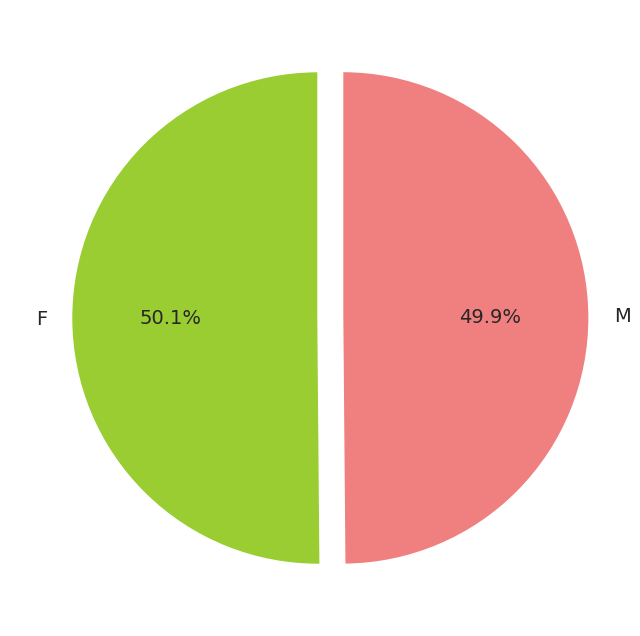

In [277]:
# Verifiquemos la distribución por sexo en nuestra base
# Determinamos tamaño del grafico
plt.rcParams['figure.figsize'] = 8,8

# tolist() convertirá el índice en una lista para una fácil manipulación
labels = df_['sexo'].value_counts().index.tolist()

# Convertir recuentos de valores a una lista
sizes = df_['sexo'].value_counts().tolist()

explode = (0, 0.1)

# Seteamos colores del grafico
colors = ['yellowgreen', 'lightcoral']

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',startangle=90, textprops={'fontsize': 14})
plt.show()

Tenemos casi la misma proporcion de hombres que de mujeres

In [278]:
#Descriptivo Variables Numericas
df_.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

,course_id,edad,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
count,1.044210e+05,104421.000000,104421.000000,1.044210e+05,1.044210e+05,1.044210e+05,104421.000000,104421.000000,104421.000000,104421.000000,104421.000000,104421.000000,104421.000000,104421.000000,104421.000000
mean,3.060238e+17,23.523554,1.502073,1.817233e+09,1.581995e+09,1.768400e+09,79.046743,78.943929,78.916703,294.745980,4.503998,4.001743,295.184110,0.042338,0.500560
std,3.162108e+17,3.459470,0.499998,1.923363e+08,1.235822e+08,1.183774e+08,11.512420,11.597226,11.636987,115.422726,1.705938,2.000449,115.475361,0.201361,0.500002
min,1.114445e+17,18.000000,1.000000,1.494000e+09,1.382400e+09,1.569600e+09,60.000000,60.000000,60.000000,100.000000,2.000000,1.000000,100.000000,0.000000,0.000000
10%,1.114445e+17,19.000000,1.000000,1.555200e+09,1.414800e+09,1.605600e+09,63.000000,63.000000,63.000000,138.000000,2.000000,1.000000,138.000000,0.000000,0.000000
20%,1.114445e+17,20.000000,1.000000,1.620000e+09,1.447200e+09,1.645200e+09,67.000000,67.000000,67.000000,176.000000,3.000000,2.000000,176.000000,0.000000,0.000000
30%,1.114445e+17,21.000000,1.000000,1.681200e+09,1.494000e+09,1.684800e+09,71.000000,71.000000,70.000000,214.000000,3.000000,3.000000,214.000000,0.000000,0.000000
40%,1.333445e+17,22.000000,1.000000,1.746000e+09,1.537200e+09,1.724400e+09,75.000000,74.000000,74.000000,252.000000,4.000000,3.000000,252.000000,0.000000,0.000000
50%,1.333445e+17,24.000000,2.000000,1.810800e+09,1.580400e+09,1.764000e+09,79.000000,79.000000,79.000000,291.000000,5.000000,4.000000,290.000000,0.000000,1.000000
60%,1.333445e+17,25.000000,2.000000,1.879200e+09,1.623600e+09,1.807200e+09,83.000000,83.000000,83.000000,332.000000,5.000000,5.000000,332.000000,0.000000,1.000000


In [279]:
# Definimos plot para la exploracion visual
def expl_visual(df_histograma,field):

  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
  mean=df_histograma[field].mean()
  median=df_histograma[field].median()
  mode=df_histograma[field].mode().values[0]

  sns.boxplot(data=df_histograma, x=field, ax=ax_box)
  ax_box.axvline(mean, color='r', linestyle='--')
  ax_box.axvline(median, color='g', linestyle='-')
  ax_box.axvline(mode, color='b', linestyle='-')

  sns.histplot(data=df_histograma, x=field, ax=ax_hist, kde=True)
  ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
  ax_hist.axvline(median, color='g', linestyle='-', label="Median")
  ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")

  ax_hist.legend()

  ax_box.set(xlabel='')
  plt.show()

  print('Media = ',mean)
  print('Mediana = ',median)
  print('Moda principal = ',mode)

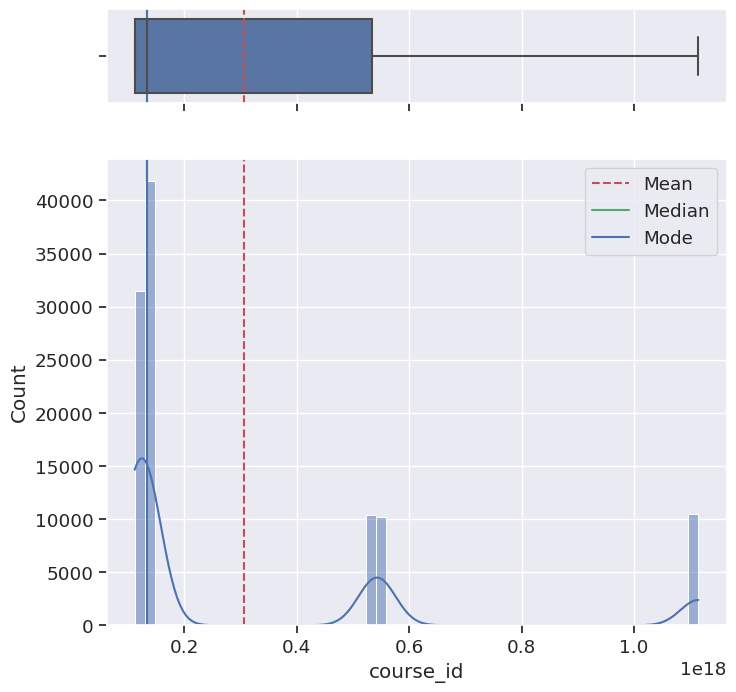

Media =  3.060237833351788e+17
Mediana =  1.3334447778833366e+17
Moda principal =  133344499988333664


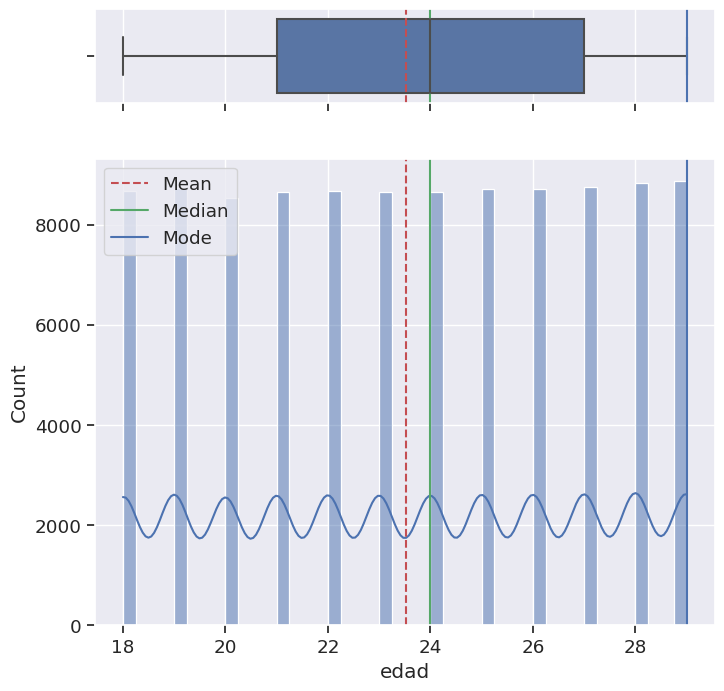

Media =  23.523553691307303
Mediana =  24.0
Moda principal =  29


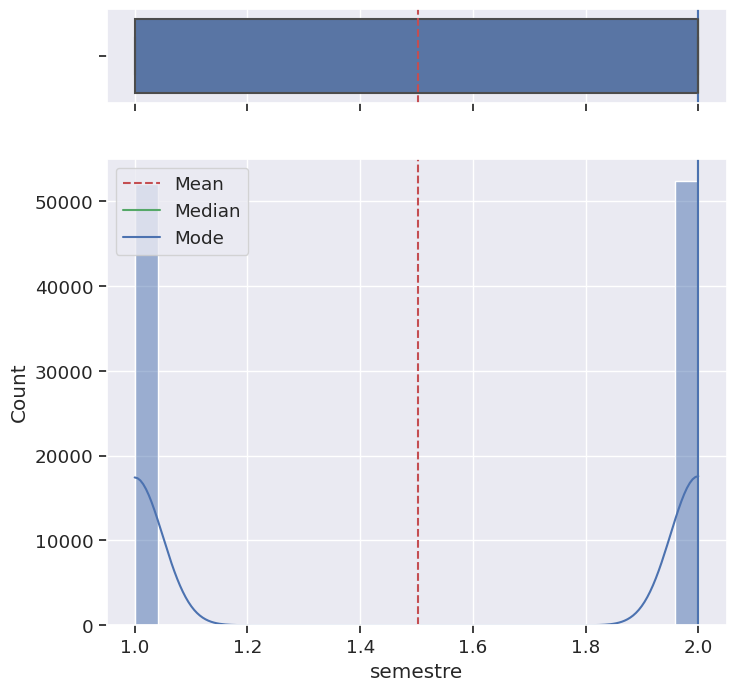

Media =  1.5020733377385775
Mediana =  2.0
Moda principal =  2


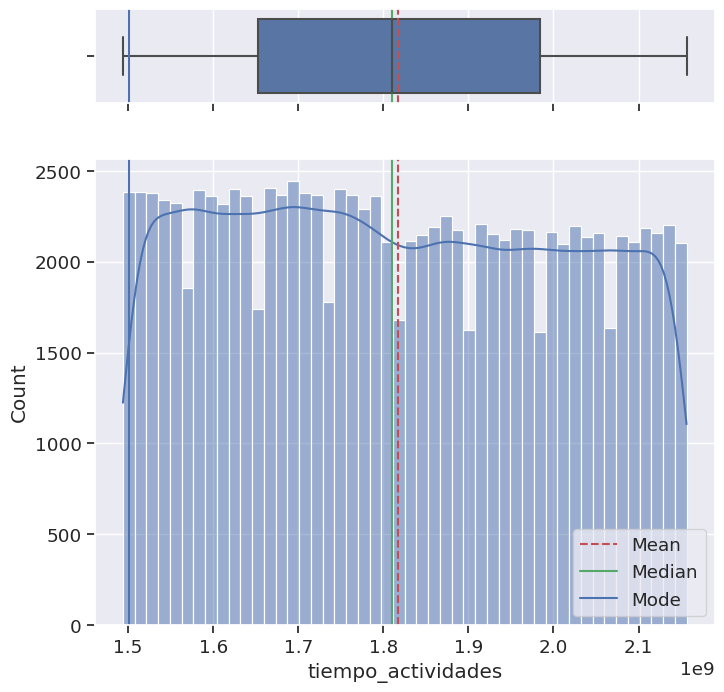

Media =  1817233361.1055248
Mediana =  1810800000.0
Moda principal =  1501200000.0


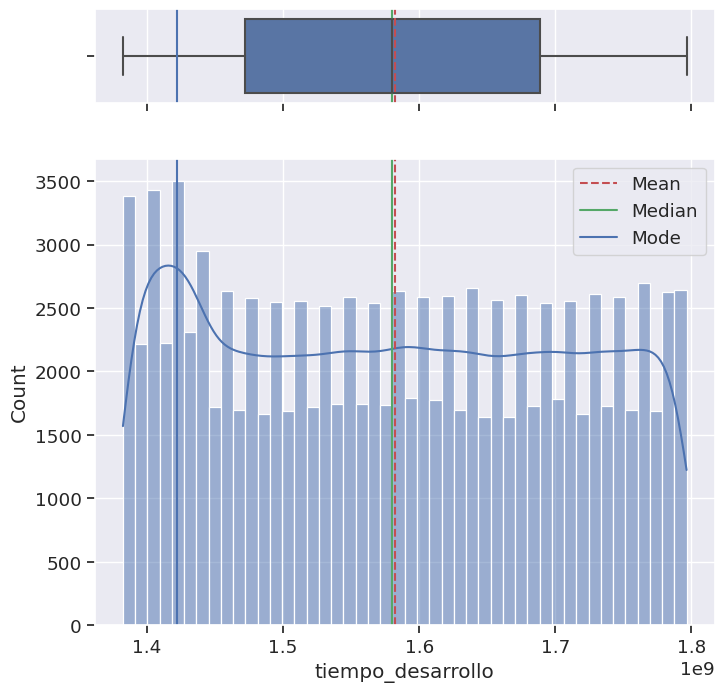

Media =  1581995368.7476656
Mediana =  1580400000.0
Moda principal =  1422000000.0


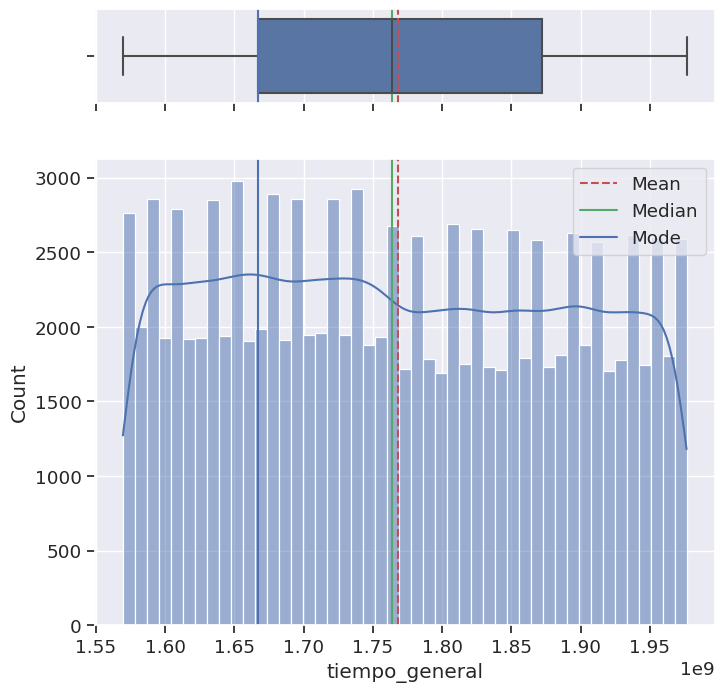

Media =  1768400080.443589
Mediana =  1764000000.0
Moda principal =  1666800000.0


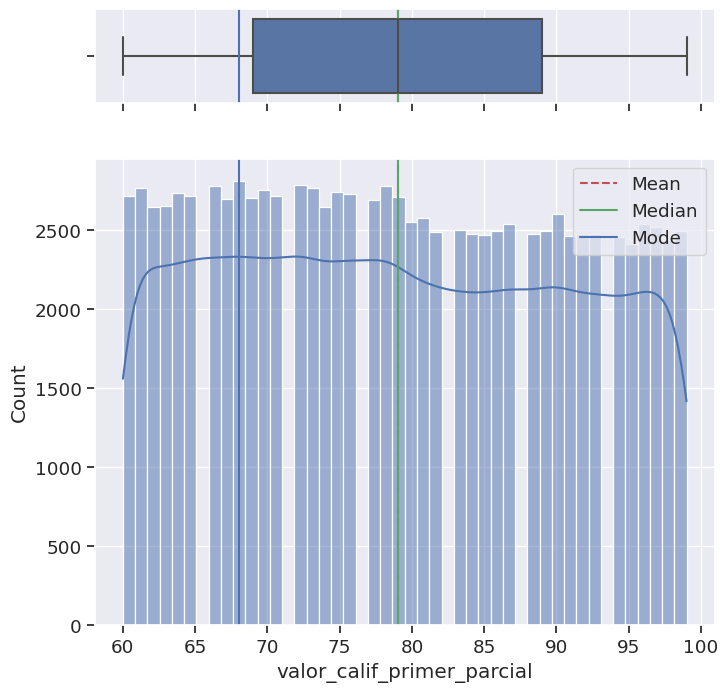

Media =  79.04674347114086
Mediana =  79.0
Moda principal =  68.0


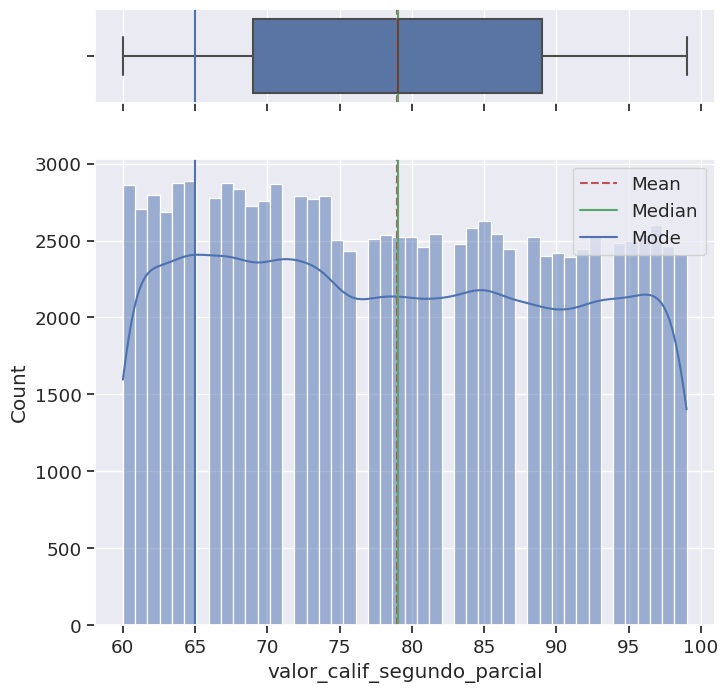

Media =  78.94392890318997
Mediana =  79.0
Moda principal =  65.0


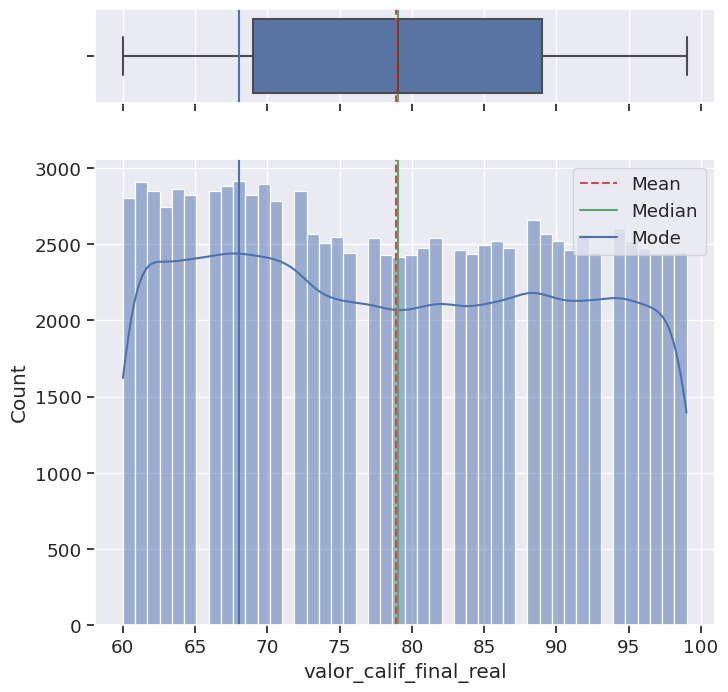

Media =  78.91670257898315
Mediana =  79.0
Moda principal =  68.0


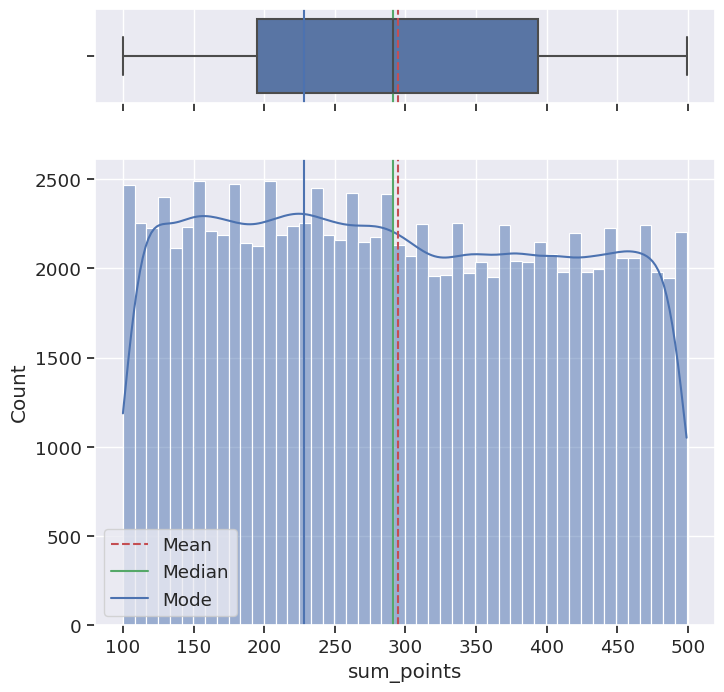

Media =  294.74598021470774
Mediana =  291.0
Moda principal =  228.0


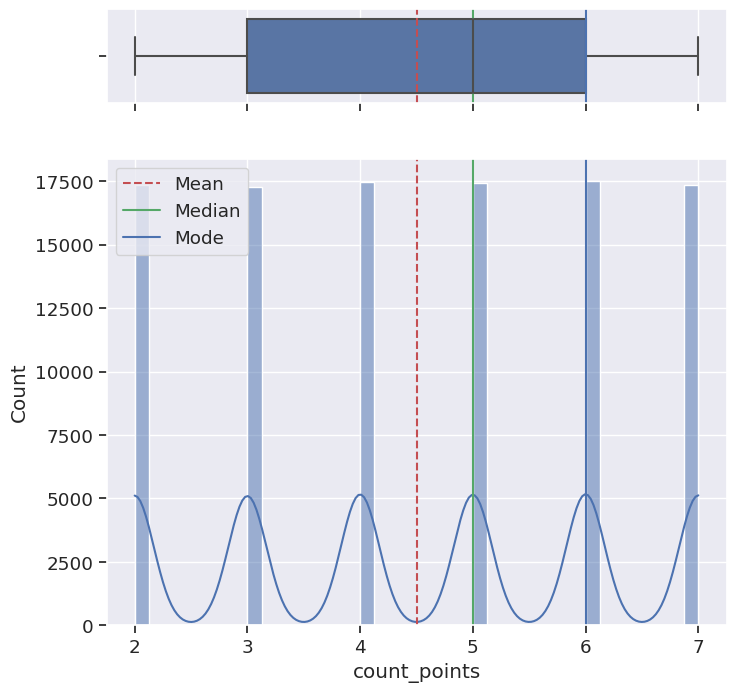

Media =  4.503998237902338
Mediana =  5.0
Moda principal =  6.0


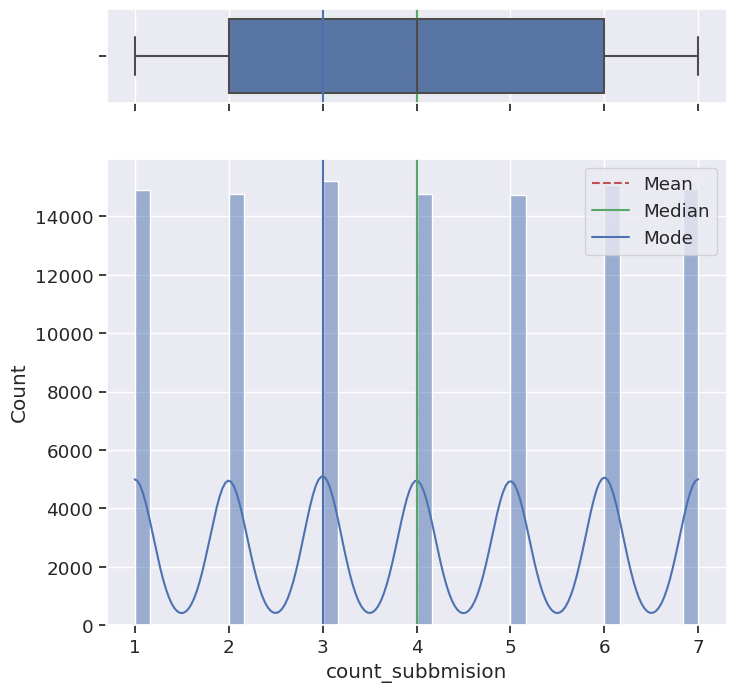

Media =  4.001742944426887
Mediana =  4.0
Moda principal =  3.0


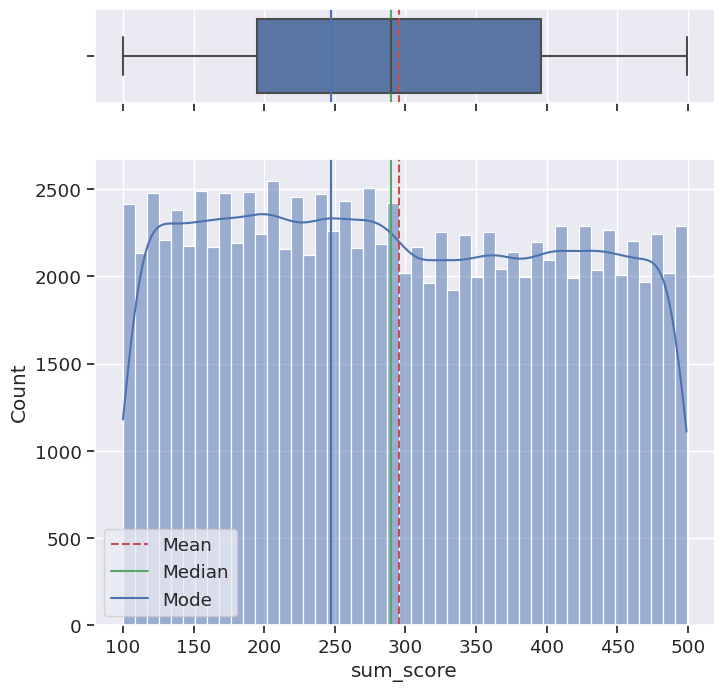

Media =  295.18411047586216
Mediana =  290.0
Moda principal =  247.0


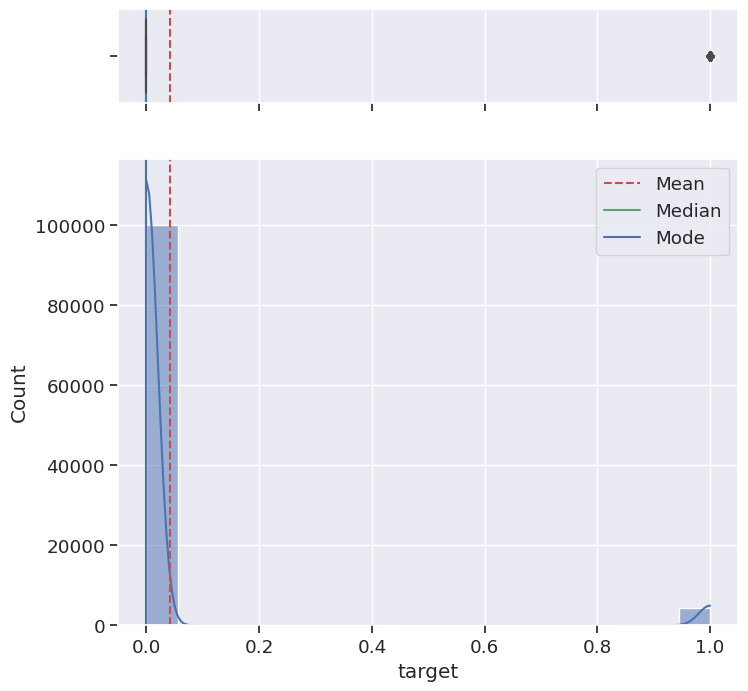

Media =  0.04233822698499344
Mediana =  0.0
Moda principal =  0


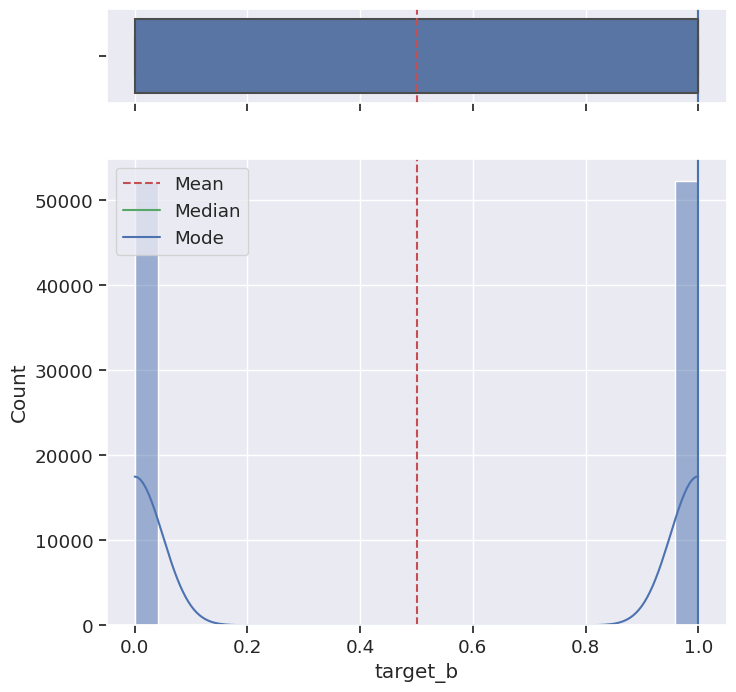

Media =  0.5005602321372138
Mediana =  1.0
Moda principal =  1


In [280]:
# Se aplica la función de exploración para visualizar la distribución de variables cuantitativas
for i in df_.describe().columns:
    expl_visual(df_,i)

Salvo cierto sesgo hacia la izquierda de algunas variables, no se observan problemas con la distribución de datos. Eso si, es dificil determinar si los microsegundos son una medida valida, por lo que procederemos a crear columnas equivalentes en segundo y minutos.

Por otrio lado, se observa que las variables targuet tiene distribuciones totalmente distintas. Mientras que targuet esta compuesta casi en su totalidad por ceros, taguet_b esta distribuida casi que equitativamente en 0 y 1.

A los fines de entrenar un algoritmo clasificatorio, esta última sería mas apropiada debido a la preencia de ambos valores y no tener que solucionar el problema de tener una variable targuet desbalanceada.

## Análisis Bivariado

In [281]:
df_.head()

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,count_subbmision,sum_score,target,target_b
0,FG256,111444477788333664,Idiomas,1342795678817385,M,25,2021-01,2,1.720800e+09,1.706400e+09,1.965600e+09,87.0,98.0,89.0,443.0,5.0,6.0,279.0,0,1
1,DE5355,133344477788333664,MatemÃ¡tica,2370785941394635,F,28,2021-01,2,1.972800e+09,1.731600e+09,1.879200e+09,79.0,97.0,92.0,266.0,5.0,2.0,256.0,0,1
2,HI4650,133344477788333664,MatemÃ¡tica,1812868984238778,M,26,2021-02,1,1.872000e+09,1.429200e+09,1.735200e+09,76.0,65.0,98.0,481.0,6.0,5.0,369.0,0,0
3,NM4364,133344499988333664,Lengua,-135586768863004,F,18,2023-02,1,2.030400e+09,1.767600e+09,1.623600e+09,91.0,71.0,65.0,374.0,5.0,5.0,180.0,0,0
4,JK3568,111444477488373664,Lengua,-2150952171478082,F,18,2020-02,2,1.800000e+09,1.688400e+09,1.972800e+09,68.0,88.0,60.0,360.0,4.0,2.0,107.0,0,0


In [282]:
def plot_percentage_by_category(df, x_col, y_col, title):
    count_table = df.groupby([x_col, y_col]).size().unstack().fillna(0)
    percentage_table = count_table.div(count_table.sum(axis=1), axis=0) * 100

    fig = px.bar(percentage_table, barmode='relative')
    fig.update_layout(
        xaxis_title=x_col,
        yaxis_title='Percentage (%)',
        title=title
    )
    fig.show()

# Estudios por Sexo
plot_percentage_by_category(df_, 'area', 'sexo', 'Estudios por Sexo')


Por curso se cuenta practicamente con la misma cantidad de hombres y mujeres

In [283]:
# Estudios por edad
plot_percentage_by_category(df_, 'area', 'edad', 'Estudios por Edad')

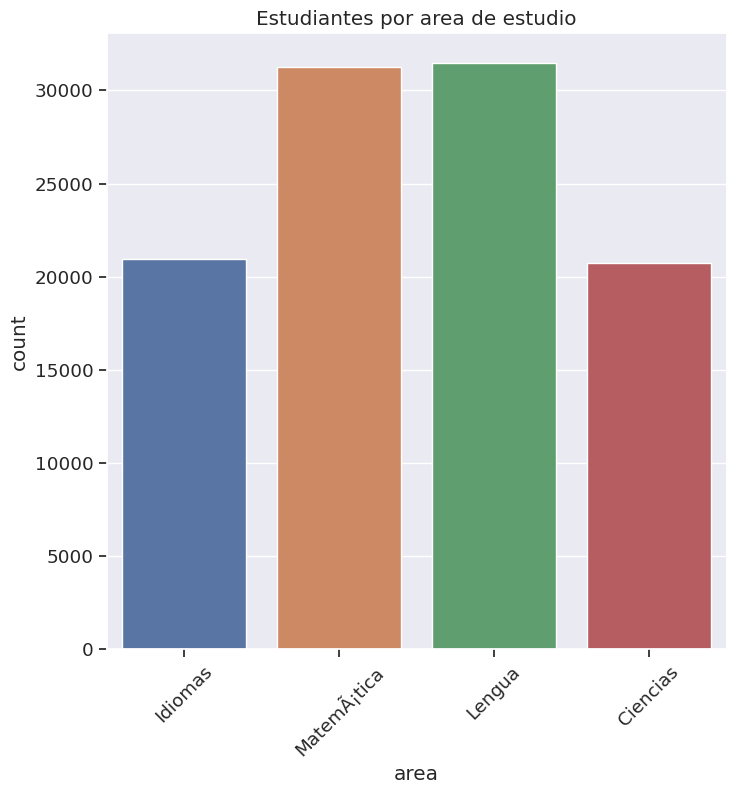

In [284]:
#Definimos funcion countplot
def plot_count_distribution(data, column, title):
    ax = sns.countplot(x=data[column])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)
    plt.show()

# Verificamos la distribución del segmento asignado a la reserva
plot_count_distribution(df_, 'area', 'Estudiantes por area de estudio')

In [285]:
# Estudios por semestre
plot_percentage_by_category(df_, 'area', 'semestre', 'Estudios por Semestre')

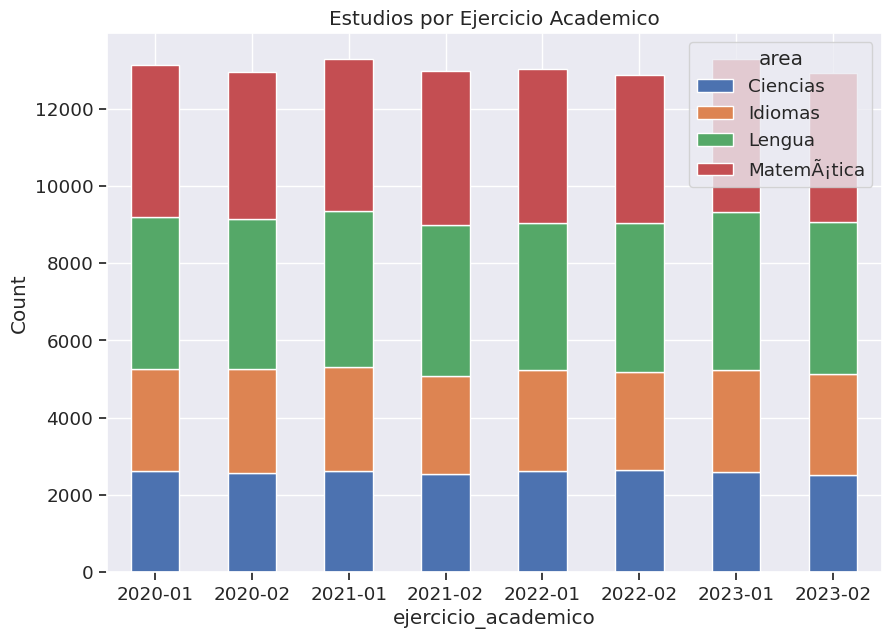

In [286]:
def plot_count_by_category(df, x_col, y_col, title):
    count_table = df.groupby([x_col, y_col]).size().unstack().fillna(0)
    count_table.plot(kind='bar', stacked=True, figsize=(10, 7))
    plt.xlabel(x_col)
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()

# Estudios por ejercicio academico
plot_count_by_category(df_, 'ejercicio_academico', 'area', 'Estudios por Ejercicio Academico')

Conclusiones parciales:
1. A nivel areas de estudio, Matematicas y Lengua son las dos con mas matriculados.
2. Se observa una distribucion equitativa por sexo y edad entre las áeras de estudio
3. Lo mismo ocurre con los semestres de estudio

In [287]:
df_.columns

Index(['matricula', 'course_id', 'area', 'user_id', 'sexo', 'edad',
       'ejercicio_academico', 'semestre', 'tiempo_actividades',
       'tiempo_desarrollo', 'tiempo_general', 'valor_calif_primer_parcial',
       'valor_calif_segundo_parcial', 'valor_calif_final_real', 'sum_points',
       'count_points', 'count_subbmision', 'sum_score', 'target', 'target_b'],
      dtype='object')

In [288]:
def plot_pivot_median_plotly(df, index_col, values_col, title):
    pivot_table = df.pivot_table(index=index_col, values=values_col, aggfunc='median').reset_index()

    fig = px.bar(pivot_table, x=index_col, y=values_col, color=index_col)

    fig.update_layout(
        title=title,
        xaxis_title=index_col,
        yaxis_title=values_col
    )

    fig.show()

# Calificacion promedio de primer parcial por area
plot_pivot_median_plotly(df_, 'area', 'valor_calif_primer_parcial', 'Calificacion promedio de primer parcial por area')


In [289]:
# Calificacion promedio de segundo parcial por area
plot_pivot_median_plotly(df_, 'area', 'valor_calif_segundo_parcial', 'Calificacion promedio de segundo parcial por area')

In [290]:
# Calificacion promedio final por area
plot_pivot_median_plotly(df_, 'area', 'valor_calif_final_real', 'Calificacion promedio del final por área')

No se observan grandes diferencias entre las calificaciones promedio por área

## Analisis variable targuet

In [291]:
# Targuet por Sexo
plot_percentage_by_category(df_, 'target_b', 'sexo', 'Target por sexo')

In [292]:
# Target por edad
plot_percentage_by_category(df_, 'target_b', 'edad', 'Target por Edad')

In [293]:
# Target por area
plot_percentage_by_category(df_, 'area', 'target_b', 'Target por Area')

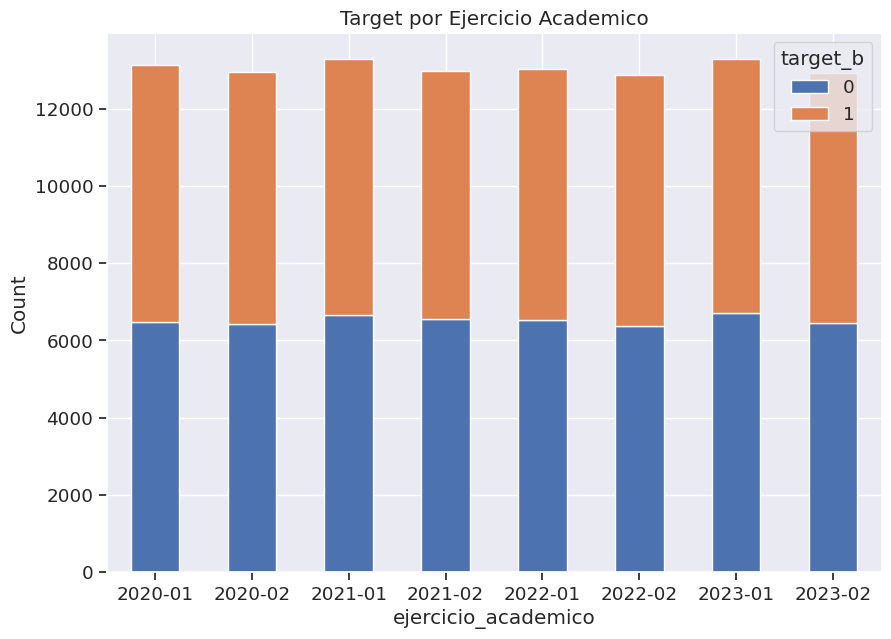

In [294]:
# Target por ejercicio academico
plot_count_by_category(df_, 'ejercicio_academico', 'target_b', 'Target por Ejercicio Academico')

In [295]:
df_.columns

Index(['matricula', 'course_id', 'area', 'user_id', 'sexo', 'edad',
       'ejercicio_academico', 'semestre', 'tiempo_actividades',
       'tiempo_desarrollo', 'tiempo_general', 'valor_calif_primer_parcial',
       'valor_calif_segundo_parcial', 'valor_calif_final_real', 'sum_points',
       'count_points', 'count_subbmision', 'sum_score', 'target', 'target_b'],
      dtype='object')

In [296]:
# Calificacion promedio final por target
plot_pivot_median_plotly(df_, 'target_b', 'valor_calif_final_real', 'Calificacion promedio del final por target')

Nuestra variable target se distribuye de manera equitativa entre las principales variables categoricas de nuestro dataset

## Feature engineering

In [297]:
# Convertir las columnas de microsegundos a segundos
df_['tiempo_actividades_segundos'] = df_['tiempo_actividades'] / 1e6
df_['tiempo_desarrollo_segundos'] = df_['tiempo_desarrollo'] / 1e6
df_['tiempo_general_segundos'] = df_['tiempo_general'] / 1e6

# Convertir las columnas de microsegundos a minutos
df_['tiempo_actividades_minutos'] = df_['tiempo_actividades'] / (1e6 * 60)
df_['tiempo_desarrollo_minutos'] = df_['tiempo_desarrollo'] / (1e6 * 60)
df_['tiempo_general_minutos'] = df_['tiempo_general'] / (1e6 * 60)

df_.head()

,matricula,course_id,area,user_id,sexo,edad,ejercicio_academico,semestre,tiempo_actividades,tiempo_desarrollo,...,count_subbmision,sum_score,target,target_b,tiempo_actividades_segundos,tiempo_desarrollo_segundos,tiempo_general_segundos,tiempo_actividades_minutos,tiempo_desarrollo_minutos,tiempo_general_minutos
0,FG256,111444477788333664,Idiomas,1342795678817385,M,25,2021-01,2,1.720800e+09,1.706400e+09,...,6.0,279.0,0,1,1720.8,1706.4,1965.6,28.68,28.44,32.76
1,DE5355,133344477788333664,MatemÃ¡tica,2370785941394635,F,28,2021-01,2,1.972800e+09,1.731600e+09,...,2.0,256.0,0,1,1972.8,1731.6,1879.2,32.88,28.86,31.32
2,HI4650,133344477788333664,MatemÃ¡tica,1812868984238778,M,26,2021-02,1,1.872000e+09,1.429200e+09,...,5.0,369.0,0,0,1872.0,1429.2,1735.2,31.20,23.82,28.92
3,NM4364,133344499988333664,Lengua,-135586768863004,F,18,2023-02,1,2.030400e+09,1.767600e+09,...,5.0,180.0,0,0,2030.4,1767.6,1623.6,33.84,29.46,27.06
4,JK3568,111444477488373664,Lengua,-2150952171478082,F,18,2020-02,2,1.800000e+09,1.688400e+09,...,2.0,107.0,0,0,1800.0,1688.4,1972.8,30.00,28.14,32.88


### Encoding variables area, sexo

In [298]:
# Variables a codificar
obj_cols = ["area","sexo","ejercicio_academico"]

In [299]:
# Itera a través de las columnas categóricas y aplica el One-Hot Encoder
for col in obj_cols:
    one_hot = pd.get_dummies(df_[col], prefix=col, prefix_sep='_')
    df_ = pd.concat([df_, one_hot], axis=1)
    df_.drop(col, axis=1, inplace=True)

df_.head()

,matricula,course_id,user_id,edad,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,...,sexo_F,sexo_M,ejercicio_academico_2020-01,ejercicio_academico_2020-02,ejercicio_academico_2021-01,ejercicio_academico_2021-02,ejercicio_academico_2022-01,ejercicio_academico_2022-02,ejercicio_academico_2023-01,ejercicio_academico_2023-02
0,FG256,111444477788333664,1342795678817385,25,2,1.720800e+09,1.706400e+09,1.965600e+09,87.0,98.0,...,0,1,0,0,1,0,0,0,0,0
1,DE5355,133344477788333664,2370785941394635,28,2,1.972800e+09,1.731600e+09,1.879200e+09,79.0,97.0,...,1,0,0,0,1,0,0,0,0,0
2,HI4650,133344477788333664,1812868984238778,26,1,1.872000e+09,1.429200e+09,1.735200e+09,76.0,65.0,...,0,1,0,0,0,1,0,0,0,0
3,NM4364,133344499988333664,-135586768863004,18,1,2.030400e+09,1.767600e+09,1.623600e+09,91.0,71.0,...,1,0,0,0,0,0,0,0,0,1
4,JK3568,111444477488373664,-2150952171478082,18,2,1.800000e+09,1.688400e+09,1.972800e+09,68.0,88.0,...,1,0,0,1,0,0,0,0,0,0


<ipython-input-300-f257b10e1d84>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-300-f257b10e1d84>:8: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



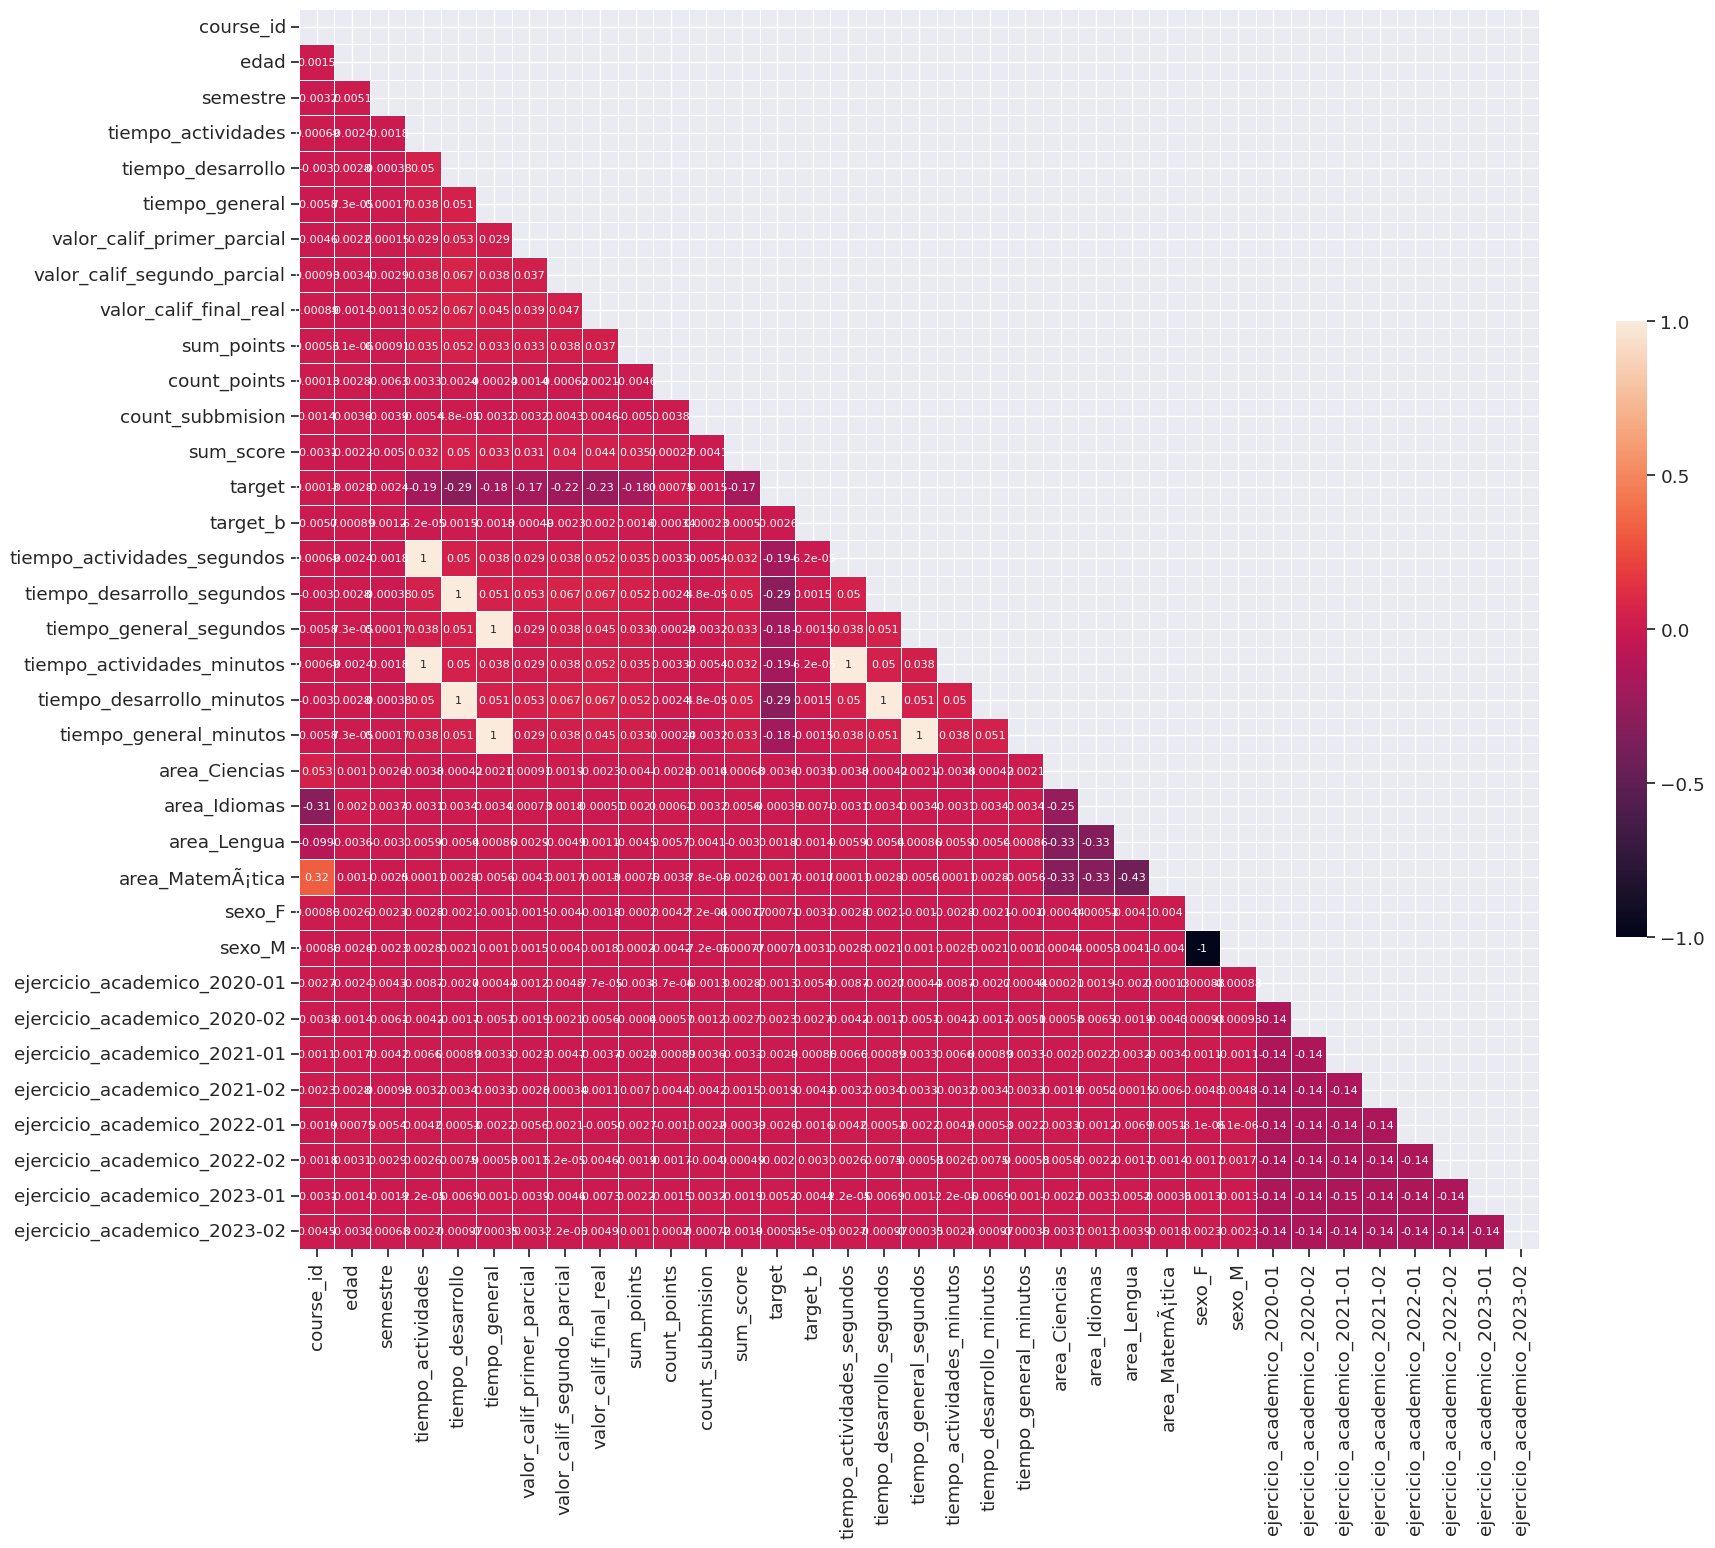

In [300]:
#Veamos la correlacion que existe entre las variables numericas
# Correlacion entre variables numericas

matriz_correlacion = df_.corr()

# Graficamos la correlacion entre las variables

mask = np.zeros_like(matriz_correlacion, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(20, 20))

heatmap = sns.heatmap(matriz_correlacion,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      #cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True, annot_kws={"fontsize":8})


ax.set_yticklabels(matriz_correlacion.columns, rotation = 0)
ax.set_xticklabels(matriz_correlacion.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Feature Selection

No hemos observado una alta correlacion entre variables, por ende utilizaremos variance threshold para descartar variables que no serían de utilidad para predecir nuestra variable target.

In [301]:
df_copy = df_.copy()

In [302]:
#Recordemos nuestro dataset
df_

,matricula,course_id,user_id,edad,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,...,sexo_F,sexo_M,ejercicio_academico_2020-01,ejercicio_academico_2020-02,ejercicio_academico_2021-01,ejercicio_academico_2021-02,ejercicio_academico_2022-01,ejercicio_academico_2022-02,ejercicio_academico_2023-01,ejercicio_academico_2023-02
0,FG256,111444477788333664,1342795678817385,25,2,1.720800e+09,1.706400e+09,1.965600e+09,87.0,98.0,...,0,1,0,0,1,0,0,0,0,0
1,DE5355,133344477788333664,2370785941394635,28,2,1.972800e+09,1.731600e+09,1.879200e+09,79.0,97.0,...,1,0,0,0,1,0,0,0,0,0
2,HI4650,133344477788333664,1812868984238778,26,1,1.872000e+09,1.429200e+09,1.735200e+09,76.0,65.0,...,0,1,0,0,0,1,0,0,0,0
3,NM4364,133344499988333664,-135586768863004,18,1,2.030400e+09,1.767600e+09,1.623600e+09,91.0,71.0,...,1,0,0,0,0,0,0,0,0,1
4,JK3568,111444477488373664,-2150952171478082,18,2,1.800000e+09,1.688400e+09,1.972800e+09,68.0,88.0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104416,DE14497,1114444777885219664,-256978922634255,18,2,1.573200e+09,1.407600e+09,1.674000e+09,71.0,68.0,...,0,1,0,0,0,0,1,0,0,0
104417,GH10727,133344477755533664,6079498920052415,24,1,1.720800e+09,1.396800e+09,1.652400e+09,71.0,61.0,...,0,1,0,0,0,0,1,0,0,0
104418,DE12331,133344477755533664,-2896990840620049,29,2,1.749600e+09,1.414800e+09,1.620000e+09,79.0,70.0,...,0,1,0,0,0,0,0,1,0,0
104419,EF15152,111444477788999664,1970096503557883,29,1,1.792800e+09,1.393200e+09,1.666800e+09,79.0,62.0,...,1,0,0,1,0,0,0,0,0,0


In [303]:
df_.drop(columns=["course_id","user_id","target"], inplace=True)

In [304]:
# Primero definimos una funcion para escalar nuestro dataset
def MinMaxScaler(df):

    df.set_index(["matricula","target_b"], inplace=True)

    # normalize data()

    scaler = preprocessing.MinMaxScaler().fit(df)
    scaled = scaler.transform(df)
    scaled = pd.DataFrame(
        scaled,
        index=df.index,
        columns=df.columns,
    )

    return scaled

# Definimos selector
def variance_threshold(df:pd.DataFrame,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

In [305]:
df_normalized = MinMaxScaler(df_)
df_normalized

,,edad,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,count_points,...,sexo_F,sexo_M,ejercicio_academico_2020-01,ejercicio_academico_2020-02,ejercicio_academico_2021-01,ejercicio_academico_2021-02,ejercicio_academico_2022-01,ejercicio_academico_2022-02,ejercicio_academico_2023-01,ejercicio_academico_2023-02
matricula,target_b,,,,,,,,,,,,,,,,,,,,,
FG256,1,0.636364,1.0,0.342391,0.782609,0.973451,0.692308,0.974359,0.743590,0.859649,0.6,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
DE5355,1,0.909091,1.0,0.722826,0.843478,0.761062,0.487179,0.948718,0.820513,0.416040,0.6,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
HI4650,0,0.727273,0.0,0.570652,0.113043,0.407080,0.410256,0.128205,0.974359,0.954887,0.8,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
NM4364,0,0.000000,0.0,0.809783,0.930435,0.132743,0.794872,0.282051,0.128205,0.686717,0.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
JK3568,0,0.000000,1.0,0.461957,0.739130,0.991150,0.205128,0.717949,0.000000,0.651629,0.4,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DE14497,1,0.000000,1.0,0.119565,0.060870,0.256637,0.282051,0.205128,0.179487,0.431078,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GH10727,0,0.545455,0.0,0.342391,0.034783,0.203540,0.282051,0.025641,0.128205,0.087719,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
DE12331,1,1.000000,1.0,0.385870,0.078261,0.123894,0.487179,0.256410,0.153846,0.471178,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [306]:
#Nos Plantemoas dos casos, uno donde el threshold es 0.09 y el otro 0.001

df_normalized_filtered = variance_threshold(df_normalized,0.09)
df_normalized_filtered_2 = variance_threshold(df_normalized,0.01)

In [307]:
df_normalized_filtered.shape , df_normalized_filtered_2.shape

((104421, 18), (104421, 32))

In [308]:
#Filtramos columnas en nuestro dataset original
def columns(df, df_norm):
  columns=df_norm.columns
  df = df.filter(items=columns).reset_index()
  return df.set_index("matricula")

In [309]:
df_1 = columns(df_,df_normalized_filtered)
df_1

,target_b,edad,semestre,count_points,count_subbmision,area_Ciencias,area_Idiomas,area_Lengua,area_MatemÃ¡tica,sexo_F,sexo_M,ejercicio_academico_2020-01,ejercicio_academico_2020-02,ejercicio_academico_2021-01,ejercicio_academico_2021-02,ejercicio_academico_2022-01,ejercicio_academico_2022-02,ejercicio_academico_2023-01,ejercicio_academico_2023-02
matricula,,,,,,,,,,,,,,,,,,,
FG256,1,25,2,5.0,6.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
DE5355,1,28,2,5.0,2.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
HI4650,0,26,1,6.0,5.0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
NM4364,0,18,1,5.0,5.0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
JK3568,0,18,2,4.0,2.0,0,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DE14497,1,18,2,2.0,1.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
GH10727,0,24,1,7.0,3.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
DE12331,1,29,2,7.0,6.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


In [310]:
df_2 = columns(df_,df_normalized_filtered_2)
df_2

,target_b,edad,semestre,tiempo_actividades,tiempo_desarrollo,tiempo_general,valor_calif_primer_parcial,valor_calif_segundo_parcial,valor_calif_final_real,sum_points,...,sexo_F,sexo_M,ejercicio_academico_2020-01,ejercicio_academico_2020-02,ejercicio_academico_2021-01,ejercicio_academico_2021-02,ejercicio_academico_2022-01,ejercicio_academico_2022-02,ejercicio_academico_2023-01,ejercicio_academico_2023-02
matricula,,,,,,,,,,,,,,,,,,,,,
FG256,1,25,2,1.720800e+09,1.706400e+09,1.965600e+09,87.0,98.0,89.0,443.0,...,0,1,0,0,1,0,0,0,0,0
DE5355,1,28,2,1.972800e+09,1.731600e+09,1.879200e+09,79.0,97.0,92.0,266.0,...,1,0,0,0,1,0,0,0,0,0
HI4650,0,26,1,1.872000e+09,1.429200e+09,1.735200e+09,76.0,65.0,98.0,481.0,...,0,1,0,0,0,1,0,0,0,0
NM4364,0,18,1,2.030400e+09,1.767600e+09,1.623600e+09,91.0,71.0,65.0,374.0,...,1,0,0,0,0,0,0,0,0,1
JK3568,0,18,2,1.800000e+09,1.688400e+09,1.972800e+09,68.0,88.0,60.0,360.0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DE14497,1,18,2,1.573200e+09,1.407600e+09,1.674000e+09,71.0,68.0,67.0,272.0,...,0,1,0,0,0,0,1,0,0,0
GH10727,0,24,1,1.720800e+09,1.396800e+09,1.652400e+09,71.0,61.0,65.0,135.0,...,0,1,0,0,0,0,1,0,0,0
DE12331,1,29,2,1.749600e+09,1.414800e+09,1.620000e+09,79.0,70.0,66.0,288.0,...,0,1,0,0,0,0,0,1,0,0


## Modelado

Plantearemos 4 algoritmos para predecir nuestra variable binaria: regresion logistica, random forest, gradient boosting y xgboost.

### Caso df_1

In [345]:
# Separamos nuestro dataset hotels_1 en train y test
X_train, X_test, y_train, y_test = train_test_split(
    df_1.drop(labels=["target_b"], axis=1),
    df_1['target_b'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73094, 18), (31327, 18), (73094,), (31327,))

Random Forest - Train set:
Precision: 0.53, Recall: 0.35, F1-Score: 0.42, AUC-ROC: 0.53, Accuracy: 0.52
Random Forest - Test set:
Precision: 0.51, Recall: 0.33, F1-Score: 0.40, AUC-ROC: 0.50, Accuracy: 0.50


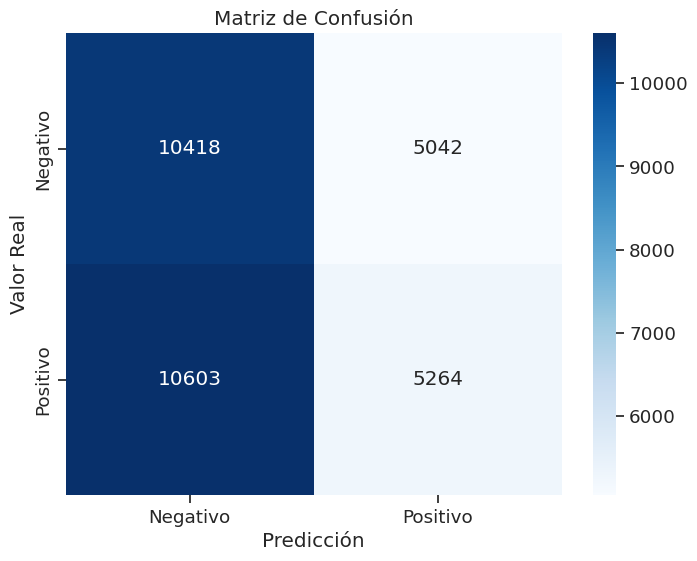

In [349]:
def evaluate_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    model.fit(X_train, y_train)

    print('Random Forest - Train set:')
    train_pred = model.predict(X_train)
    train_precision = precision_score(y_train, train_pred)
    train_recall = recall_score(y_train, train_pred)
    train_f1 = f1_score(y_train, train_pred)
    train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f'Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1-Score: {train_f1:.2f}, AUC-ROC: {train_roc_auc:.2f}, Accuracy: {train_accuracy:.2f}')

    print('Random Forest - Test set:')
    test_pred = model.predict(X_test)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f'Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1-Score: {test_f1:.2f}, AUC-ROC: {test_roc_auc:.2f}, Accuracy: {test_accuracy:.2f}')

    # Agregar matriz de confusión
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')
    plt.show()

# Ejemplo de uso:
evaluate_random_forest(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.52, Recall: 0.48, F1-Score: 0.50, AUC-ROC: 0.54, Accuracy: 0.52
Random Forest - Test set:
Precision: 0.51, Recall: 0.46, F1-Score: 0.48, AUC-ROC: 0.51, Accuracy: 0.50


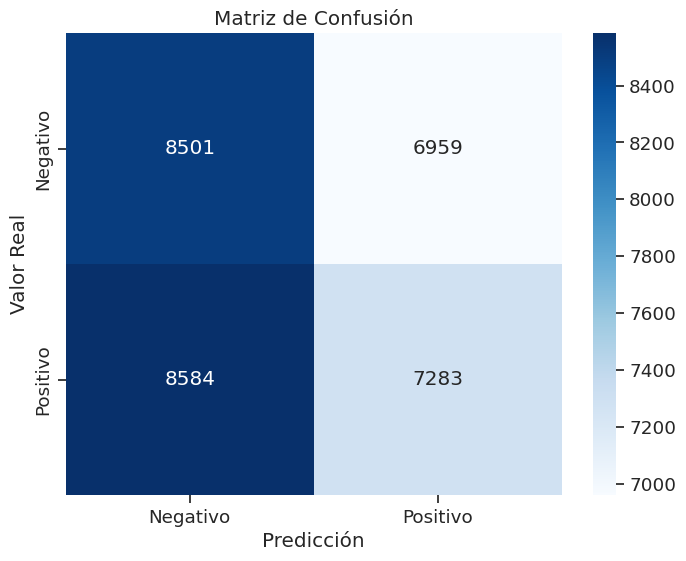

In [350]:
def evaluate_gradient_boosting(X_train, X_test, y_train, y_test):
    model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=39)
    model.fit(X_train, y_train)

    print('Random Forest - Train set:')
    train_pred = model.predict(X_train)
    train_precision = precision_score(y_train, train_pred)
    train_recall = recall_score(y_train, train_pred)
    train_f1 = f1_score(y_train, train_pred)
    train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f'Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1-Score: {train_f1:.2f}, AUC-ROC: {train_roc_auc:.2f}, Accuracy: {train_accuracy:.2f}')

    print('Random Forest - Test set:')
    test_pred = model.predict(X_test)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f'Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1-Score: {test_f1:.2f}, AUC-ROC: {test_roc_auc:.2f}, Accuracy: {test_accuracy:.2f}')

    # Agregar matriz de confusión
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')
    plt.show()

evaluate_gradient_boosting(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.51, Recall: 0.40, F1-Score: 0.45, AUC-ROC: 0.51, Accuracy: 0.51
Random Forest - Test set:
Precision: 0.51, Recall: 0.40, F1-Score: 0.45, AUC-ROC: 0.50, Accuracy: 0.50


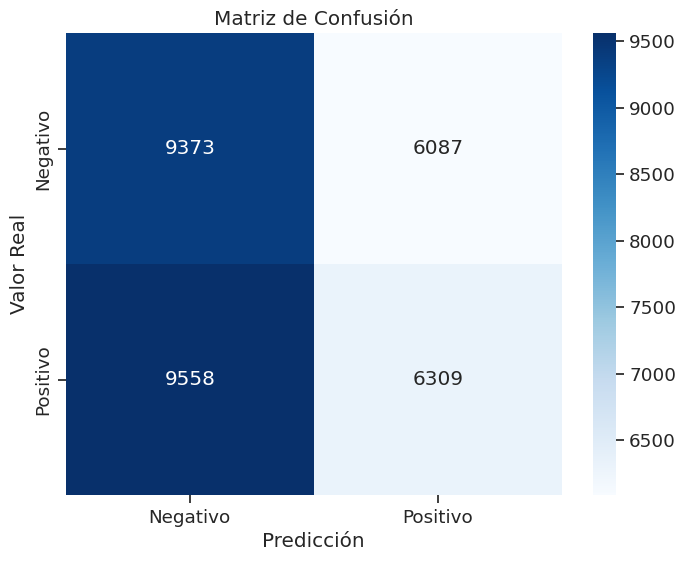

In [351]:
# Función para evaluar Logistic Regression
def evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression(random_state=39)
    model.fit(X_train, y_train)

    print('Random Forest - Train set:')
    train_pred = model.predict(X_train)
    train_precision = precision_score(y_train, train_pred)
    train_recall = recall_score(y_train, train_pred)
    train_f1 = f1_score(y_train, train_pred)
    train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f'Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1-Score: {train_f1:.2f}, AUC-ROC: {train_roc_auc:.2f}, Accuracy: {train_accuracy:.2f}')

    print('Random Forest - Test set:')
    test_pred = model.predict(X_test)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f'Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1-Score: {test_f1:.2f}, AUC-ROC: {test_roc_auc:.2f}, Accuracy: {test_accuracy:.2f}')

    # Agregar matriz de confusión
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')
    plt.show()

evaluate_logistic_regression(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.54, Recall: 0.51, F1-Score: 0.52, AUC-ROC: 0.55, Accuracy: 0.54
Random Forest - Test set:
Precision: 0.51, Recall: 0.48, F1-Score: 0.50, AUC-ROC: 0.51, Accuracy: 0.51


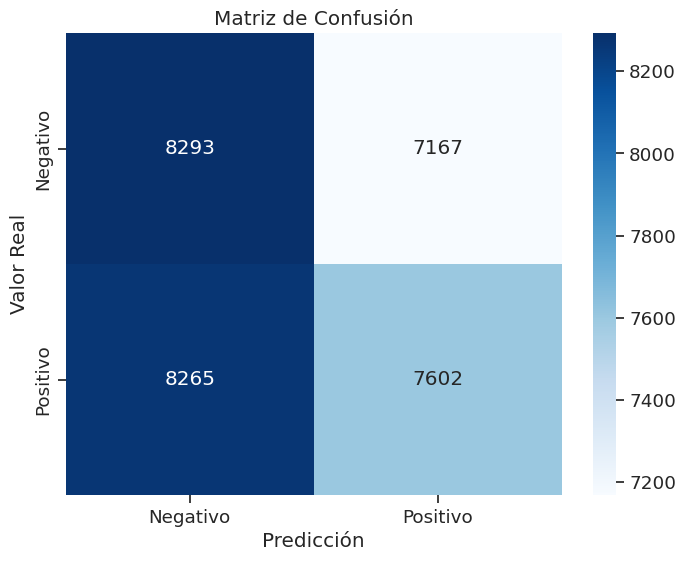

In [352]:
# Función para evaluar XGBoost
def evaluate_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=39)
    model.fit(X_train, y_train)

    print('Random Forest - Train set:')
    train_pred = model.predict(X_train)
    train_precision = precision_score(y_train, train_pred)
    train_recall = recall_score(y_train, train_pred)
    train_f1 = f1_score(y_train, train_pred)
    train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f'Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1-Score: {train_f1:.2f}, AUC-ROC: {train_roc_auc:.2f}, Accuracy: {train_accuracy:.2f}')

    print('Random Forest - Test set:')
    test_pred = model.predict(X_test)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f'Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1-Score: {test_f1:.2f}, AUC-ROC: {test_roc_auc:.2f}, Accuracy: {test_accuracy:.2f}')

    # Agregar matriz de confusión
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')
    plt.show()

evaluate_xgboost(X_train, X_test, y_train, y_test)

In [353]:
#Probemos escalado los datos a ver si obtenemos mejores resultados

from sklearn.preprocessing import StandardScaler

# Crea un objeto StandardScaler
scaler = StandardScaler()

# Ajusta el escalador a los datos de entrenamiento y transforma los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transforma los datos de prueba utilizando el mismo escalador
X_test_scaled = scaler.transform(X_test)

Random Forest - Train set:
Precision: 0.53, Recall: 0.35, F1-Score: 0.42, AUC-ROC: 0.53, Accuracy: 0.52
Random Forest - Test set:
Precision: 0.51, Recall: 0.33, F1-Score: 0.40, AUC-ROC: 0.50, Accuracy: 0.50


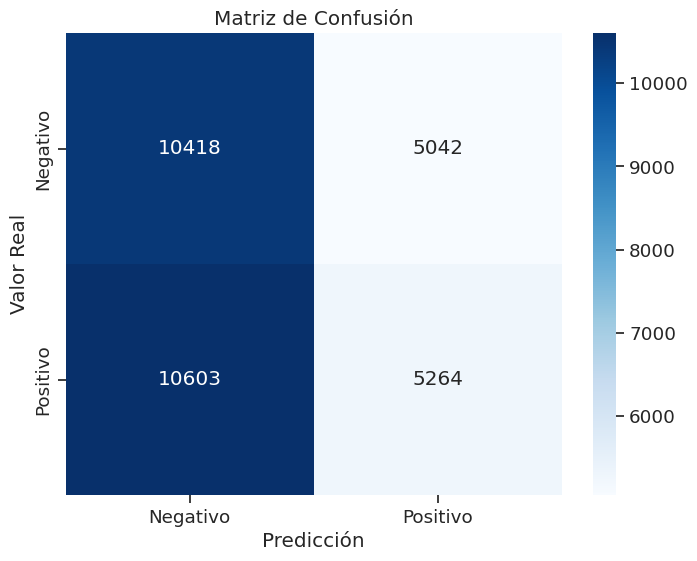

In [354]:
evaluate_random_forest(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.52, Recall: 0.48, F1-Score: 0.50, AUC-ROC: 0.54, Accuracy: 0.52
Random Forest - Test set:
Precision: 0.51, Recall: 0.46, F1-Score: 0.48, AUC-ROC: 0.51, Accuracy: 0.50


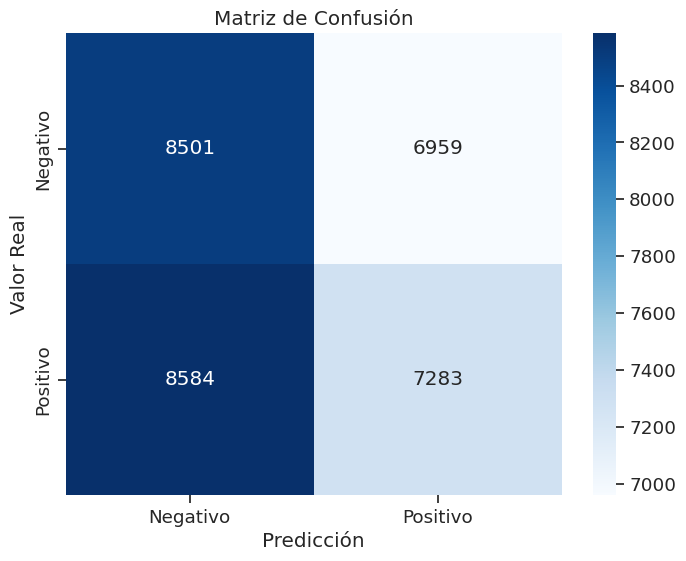

In [355]:
evaluate_gradient_boosting(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.51, Recall: 0.40, F1-Score: 0.45, AUC-ROC: 0.51, Accuracy: 0.51
Random Forest - Test set:
Precision: 0.51, Recall: 0.40, F1-Score: 0.45, AUC-ROC: 0.50, Accuracy: 0.50


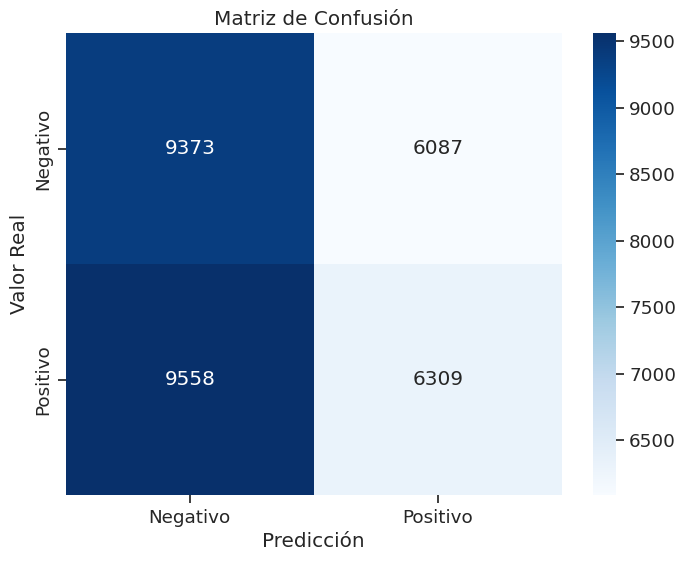

In [356]:
evaluate_logistic_regression(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.54, Recall: 0.51, F1-Score: 0.52, AUC-ROC: 0.55, Accuracy: 0.54
Random Forest - Test set:
Precision: 0.51, Recall: 0.48, F1-Score: 0.50, AUC-ROC: 0.51, Accuracy: 0.51


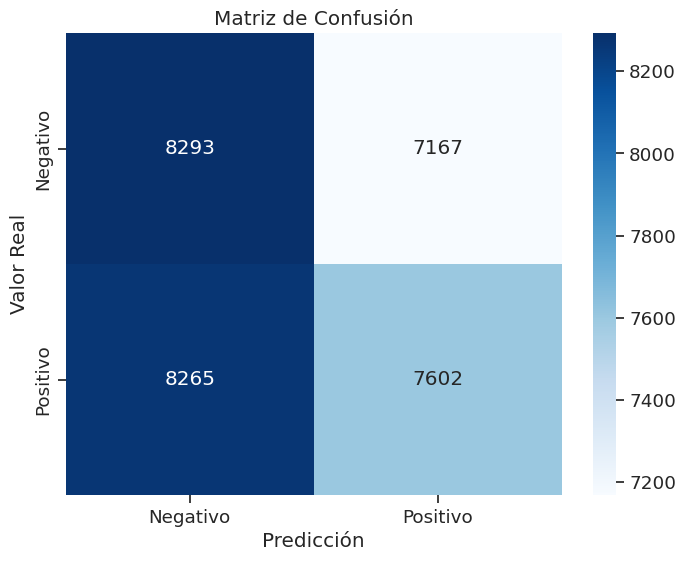

In [357]:
evaluate_xgboost(X_train, X_test, y_train, y_test)

### Caso df_2

In [358]:
# Separamos nuestro dataset hotels_1 en train y test
X_train, X_test, y_train, y_test = train_test_split(
    df_2.drop(labels=["target_b"], axis=1),
    df_2['target_b'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73094, 32), (31327, 32), (73094,), (31327,))

Random Forest - Train set:
Precision: 0.57, Recall: 0.31, F1-Score: 0.40, AUC-ROC: 0.57, Accuracy: 0.54
Random Forest - Test set:
Precision: 0.51, Recall: 0.27, F1-Score: 0.36, AUC-ROC: 0.50, Accuracy: 0.50


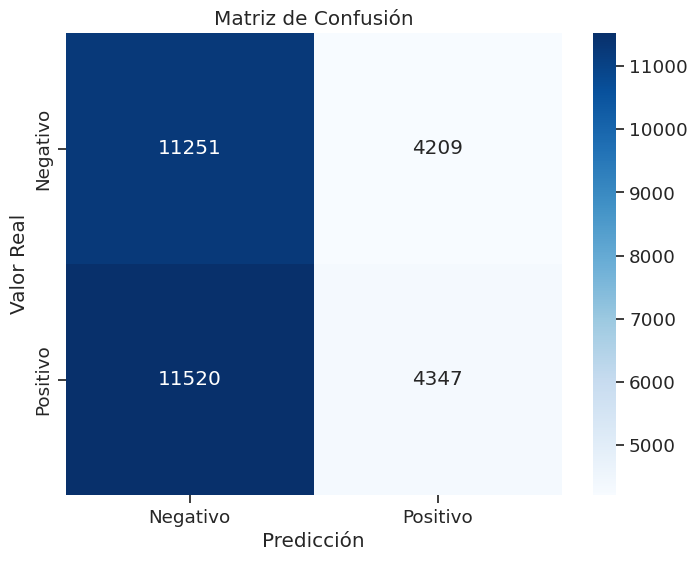

In [359]:
evaluate_random_forest(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.55, Recall: 0.52, F1-Score: 0.53, AUC-ROC: 0.57, Accuracy: 0.55
Random Forest - Test set:
Precision: 0.51, Recall: 0.47, F1-Score: 0.49, AUC-ROC: 0.50, Accuracy: 0.50


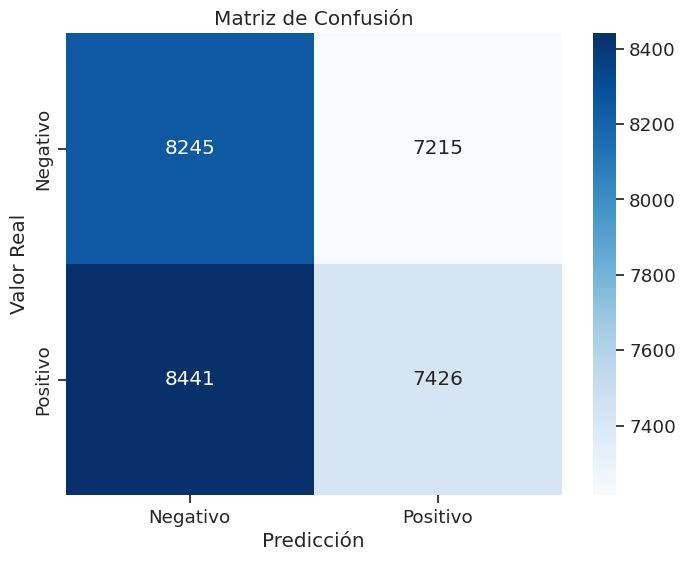

In [360]:
evaluate_gradient_boosting(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.53, Recall: 0.00, F1-Score: 0.00, AUC-ROC: 0.50, Accuracy: 0.50
Random Forest - Test set:
Precision: 0.59, Recall: 0.00, F1-Score: 0.00, AUC-ROC: 0.50, Accuracy: 0.49


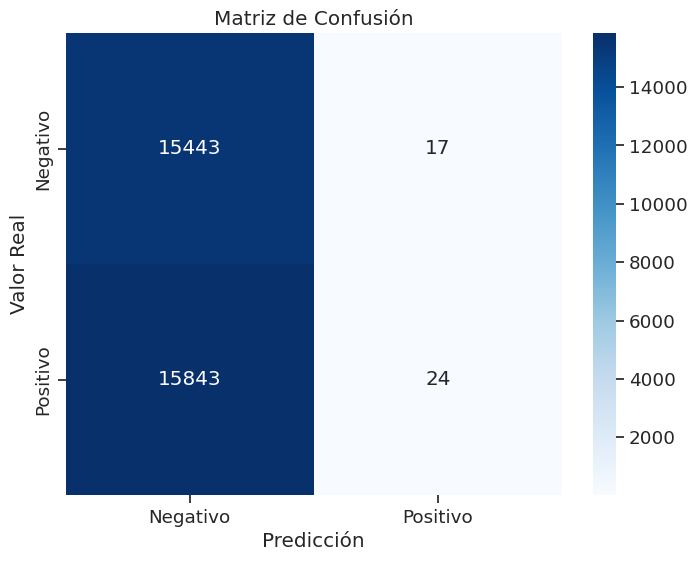

In [361]:
evaluate_logistic_regression(X_train, X_test, y_train, y_test)

Random Forest - Train set:
Precision: 0.57, Recall: 0.55, F1-Score: 0.56, AUC-ROC: 0.60, Accuracy: 0.57
Random Forest - Test set:
Precision: 0.51, Recall: 0.49, F1-Score: 0.50, AUC-ROC: 0.50, Accuracy: 0.50


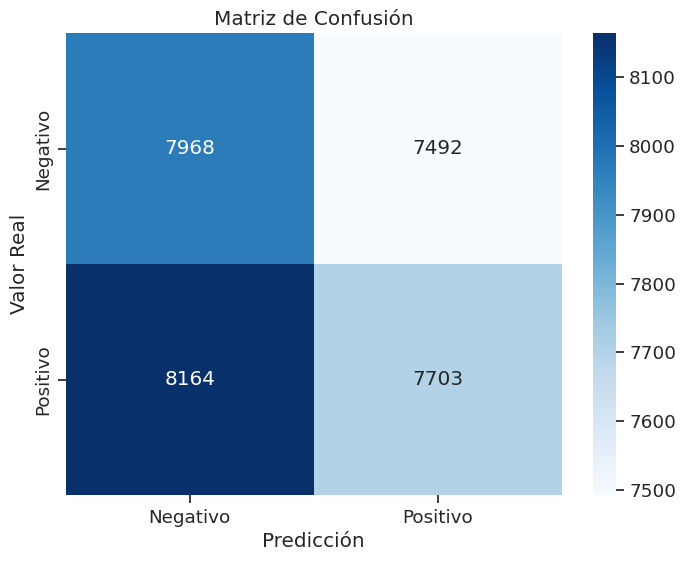

In [362]:
evaluate_xgboost(X_train, X_test, y_train, y_test)

In [363]:
#Probemos escalado los datos a ver si obtenemos mejores resultados

from sklearn.preprocessing import StandardScaler

# Crea un objeto StandardScaler
scaler = StandardScaler()

# Ajusta el escalador a los datos de entrenamiento y transforma los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transforma los datos de prueba utilizando el mismo escalador
X_test_scaled = scaler.transform(X_test)

Random Forest - Train set:
Precision: 0.57, Recall: 0.31, F1-Score: 0.40, AUC-ROC: 0.57, Accuracy: 0.54
Random Forest - Test set:
Precision: 0.51, Recall: 0.27, F1-Score: 0.36, AUC-ROC: 0.50, Accuracy: 0.50


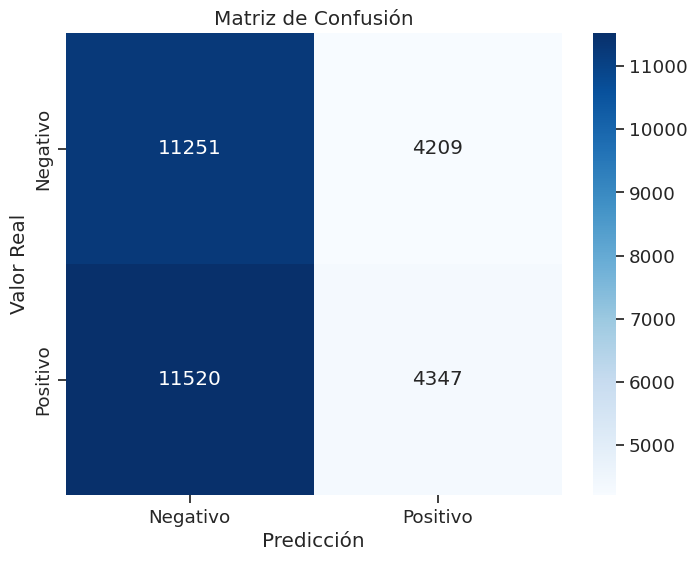

Random Forest - Train set:
Precision: 0.55, Recall: 0.52, F1-Score: 0.53, AUC-ROC: 0.57, Accuracy: 0.55
Random Forest - Test set:
Precision: 0.51, Recall: 0.47, F1-Score: 0.49, AUC-ROC: 0.50, Accuracy: 0.50


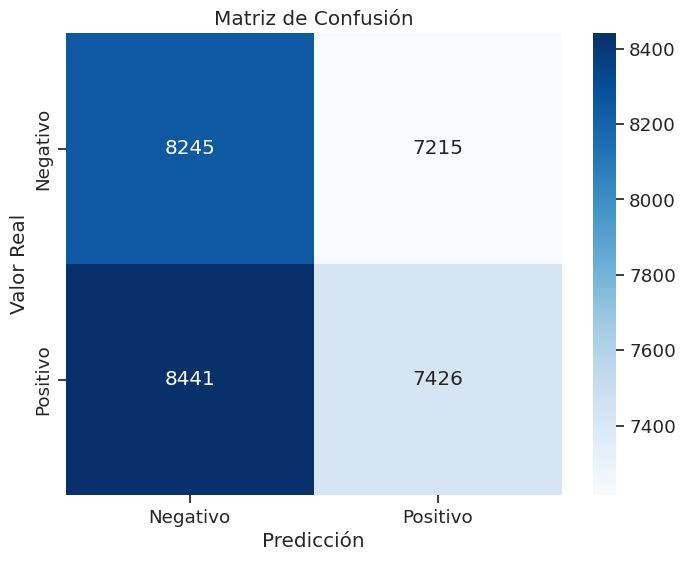

Random Forest - Train set:
Precision: 0.53, Recall: 0.00, F1-Score: 0.00, AUC-ROC: 0.50, Accuracy: 0.50
Random Forest - Test set:
Precision: 0.59, Recall: 0.00, F1-Score: 0.00, AUC-ROC: 0.50, Accuracy: 0.49


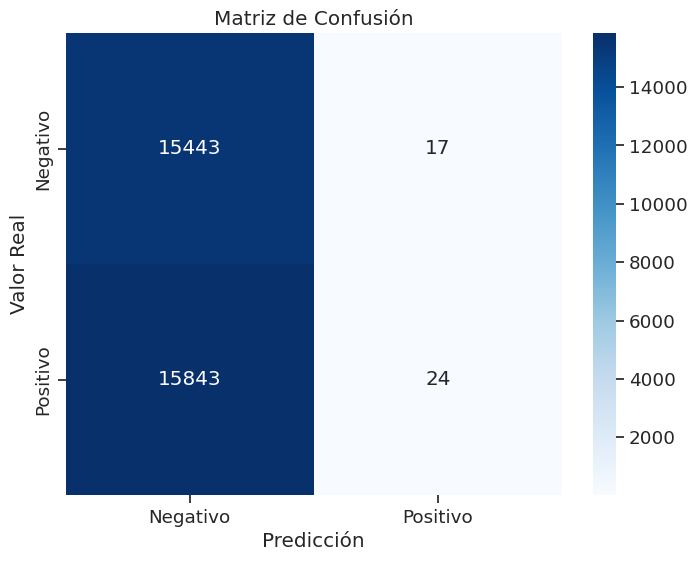

Random Forest - Train set:
Precision: 0.57, Recall: 0.55, F1-Score: 0.56, AUC-ROC: 0.60, Accuracy: 0.57
Random Forest - Test set:
Precision: 0.51, Recall: 0.49, F1-Score: 0.50, AUC-ROC: 0.50, Accuracy: 0.50


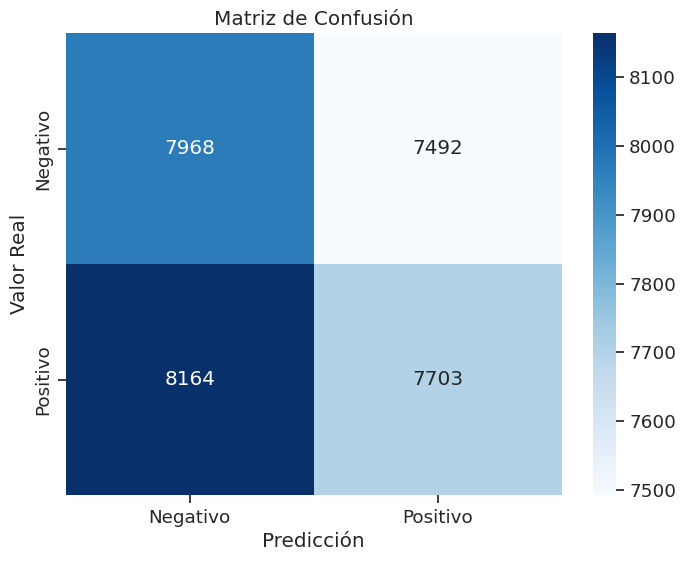

In [364]:
evaluate_random_forest(X_train, X_test, y_train, y_test)
evaluate_gradient_boosting(X_train, X_test, y_train, y_test)
evaluate_logistic_regression(X_train, X_test, y_train, y_test)
evaluate_xgboost(X_train, X_test, y_train, y_test)

Al tratarse de un modelo de clasificacion binaria optaremos por tomar el F1-Scor como medida para comparar los mkodelos y optar por el más optimo. combina precisión y exhaustividad en una sola métrica. Esta medida útil cuando deseamos un equilibrio entre la precisión y la exhaustividad y no  dar prioridad a una sobre la otra.

De todos los probados, el que mejor funcionaría seria el XGBoost con nuestra base de datos df_2 escalada.

A continuación aplicaremos el modelo y veremos la importancia que cada variable tuvo en el modelado.

## Utilizemos Shap para visualizar la importancia que cada variable tuvo en determinar la clasificación

In [365]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.7 MB/s eta 0:00:00


In [366]:
import shap

Características más importantes:
                        Feature  Importance
20                  area_Lengua    0.089208
29  ejercicio_academico_2022-02    0.061431
22                       sexo_F    0.050678
31  ejercicio_academico_2023-02    0.048756
1                      semestre    0.047198
26  ejercicio_academico_2021-01    0.046562
21             area_MatemÃ¡tica    0.044824
10             count_subbmision    0.042536
0                          edad    0.041308
28  ejercicio_academico_2022-01    0.040537
5    valor_calif_primer_parcial    0.039837
9                  count_points    0.039631
6   valor_calif_segundo_parcial    0.038821
4                tiempo_general    0.038518
11                    sum_score    0.037893
27  ejercicio_academico_2021-02    0.036417
25  ejercicio_academico_2020-02    0.036111
7        valor_calif_final_real    0.036099
3             tiempo_desarrollo    0.035673
8                    sum_points    0.034225
2            tiempo_actividades    0.032960

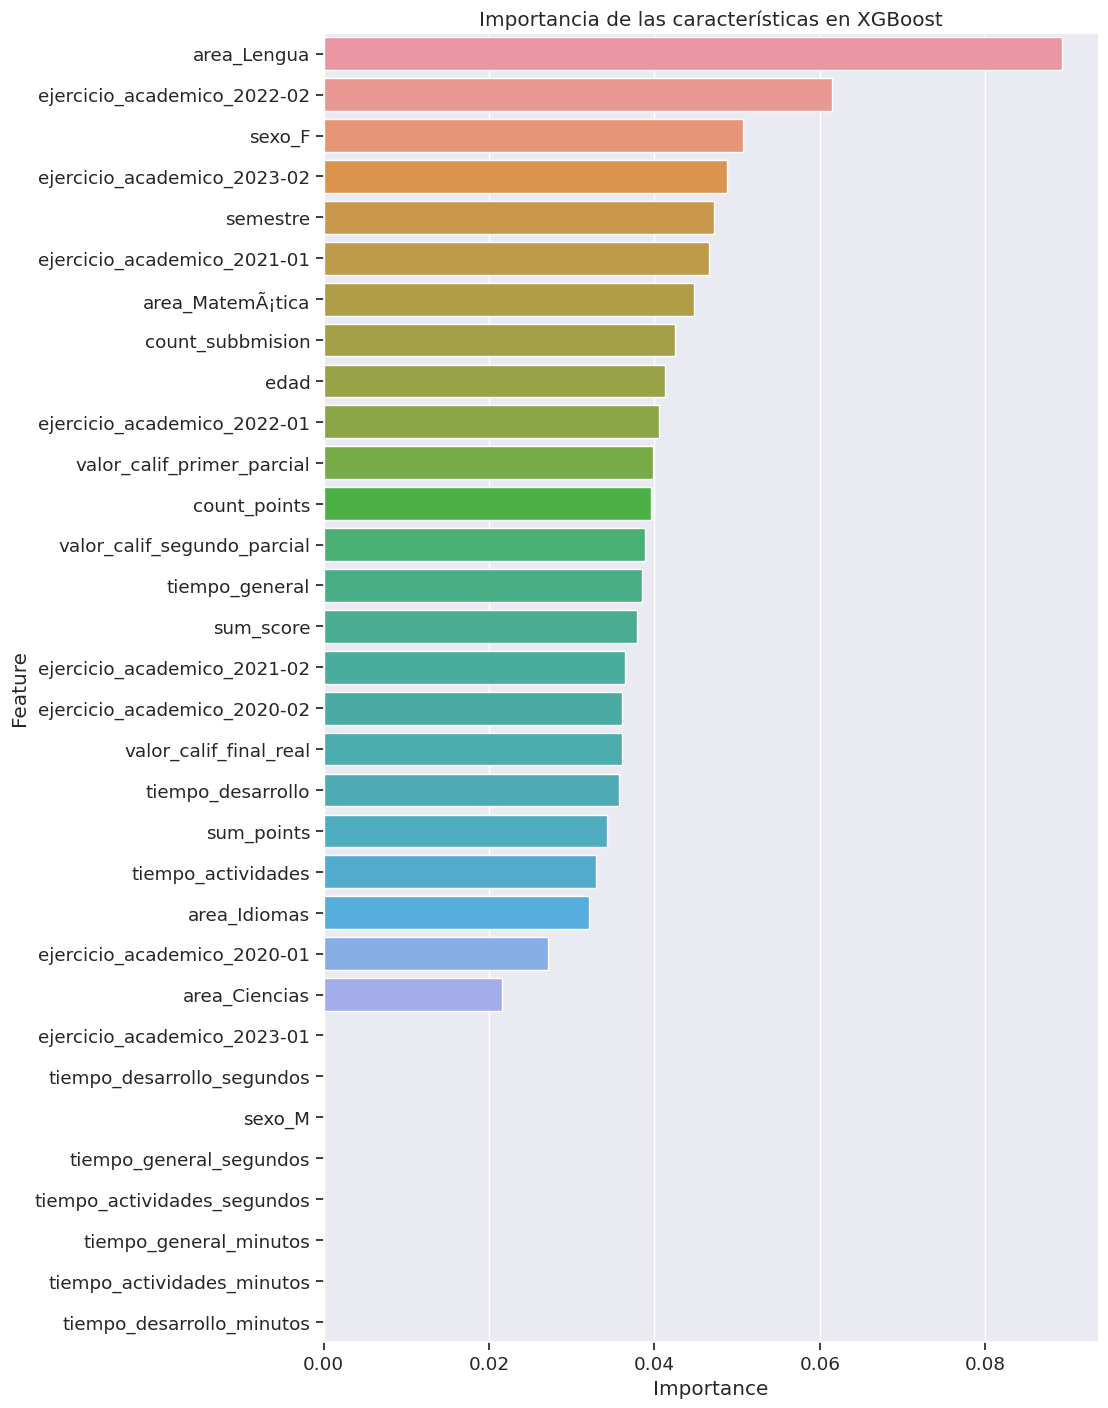

In [367]:
import xgboost as xgb

def evaluate_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=39)
    model.fit(X_train, y_train)

    # Obtenemos la importancia de las características
    feature_importance = model.feature_importances_

    # Creamos un DataFrame para visualizar las importancias de las características
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

    # Ordenamos las características por importancia en orden descendente
    feature_importance_df = feature_importance_df.sort_values (by='Importance', ascending=False)

    # Imprimimos o visualizamos las características más importantes
    print("Características más importantes:")
    print(feature_importance_df)

    # Realiza predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)


    plt.figure(figsize=(10, 17))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title("Importancia de las características en XGBoost")
    plt.show()

    return model, y_pred

# Llama a la función para entrenar el modelo y obtener la importancia de las características
xgb_model, y_pred = evaluate_xgboost(X_train, X_test, y_train, y_test)

[15:34:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


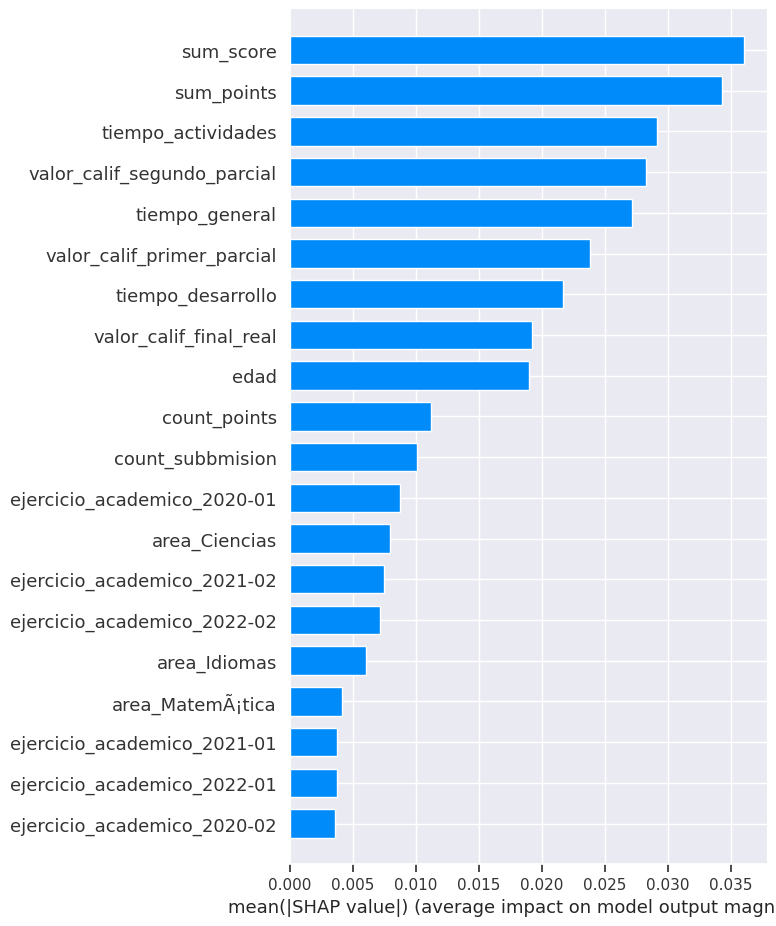

In [368]:
#Implementamos shap para determinar el aportre de cada variable

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Conclusiones

El ejercicio planteba la posibildiad de predecir con exito una variable binaria. Para ellos se seleciono la variable targetr_b ya que sus datos se encontraban balanceados, en comparacion a target que se encontraba concentrada en un solo valor.

Para ello se procedio a realizare un proceso de feature selection utilizando como medida la varianza. De las mas de 30 variables que teniamos, solo quedaron 18.

Se probaron distintos escenarios, con 4 algoritmos distintos: regresion logartimica, Random Forest, Gradient Boosting y XGBoost.

Se decidio tomar como medida de comparción entre los distintos algoritmos el F1-Score.

Finalmente se decidio que el modelo que mejores resultados presentaba era el XGBoost.
Random Forest - Train set:
Precision: 0.57, Recall: 0.55, F1-Score: 0.56, AUC-ROC: 0.60, Accuracy: 0.57
Random Forest - Test set:
Precision: 0.51, Recall: 0.49, F1-Score: 0.50, AUC-ROC: 0.50, Accuracy: 0.50

Seleccionado nuestro algoritmo procedimos aplicarlo y buscar las variables que mas importancia tuvieron en el resultado.

sum_score, sum_point y tiempo_actividades fueron las 3 principales.
De las areas de estudio, la mas determinante fue "Ciencias".
Las tres variables de tiempo en microsegundo tambien resutlaron de mucha importancia a la hora de preedcir nuestra variable target.